<a href="https://colab.research.google.com/github/Danila-Kozlov/Portfolio/blob/main/Kaggle_Leopard_Chalange_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leopard Challenge

Соревнование по Kaggle для отработки навыков по DS с помощью catboost

https://www.kaggle.com/competitions/leopard-challenge-classification

https://drive.google.com/file/d/1EkBZ87WT1FovWYblTPqyUf0jyKXsZYGU/view?usp=sharing

# Описание соревнования
Это задача регрессии на предсказание цен на недвижимость в Мельбурне.

Это данные о ценах на недвижимость в Мельбурне. Каждая строчка – это объект недвижимости, по которому известны некоторые параметры и его цена. Задача заключается в том, чтобы по этим параметрам определить цену объекта.


Предсказание модели будет оцениваться по MAPE (mean absolute Percentage error) – средняя абсолютная ошибка в процентах. На мой взгляд MAPE это одна из самых интуитивных метрик для оценки задач регрессии.

Сабмишшен – это csv-файл с id и предсказанием модели для каждого id.

# Описание столбцов (параметров объекта):
Suburb – Район  
Address – адрес  
Rooms – количество комнат  
Type – тип объекта  

> br - bedroom(s);  
h - house,cottage,villa, semi,terrace;  
u - unit, duplex;  
t - townhouse;   
dev site - development site;   
o res - other residential.

__Price__ – цена объекта  
__Method__ – метод продажи объекта:  
>   S - property sold;  
    SP - property sold prior;  
    PI - property passed in;  
    PN - sold prior not disclosed;  
    SN - sold not disclosed;  
    NB - no bid;  
    VB - vendor bid;  
    W - withdrawn prior to auction;  
    SA - sold after auction;  
    SS - sold after auction price not disclosed.  
    N/A - price or highest bid not available.  

__SellerG__ – имя риэлтора  
__Date__ – дата продажи объекта  
__Distance__ – расстояние до центрального района в километрах  
__Postcode__ – почтовый индекс  
__Bedrooms2__ – количество спален  
__Bathroom__ – количество ванных комнат  
__Car__ – количество парковочных мест  
__Landsize__ – площадь прилегающей территории  
__BuildingArea__ – площадь самого объекта  
**YearBuilt** – год постройки  
**CouncilArea** – округ  
**Lattitude** – широта  
**Longtitude** – долгота  
**Regionname** – еще одно административное деление на подобие округа  
**Propertycount** – не совсем ясно что, возможно количество объектов в округе  
__id__ – id объекта  

**Файлы**  
train.csv - выборка для обучения и валидации модели  
test.csv - выборка, на которой нужно предсказать цены и загрузить на Кагл  
sample_submission.csv - пример сабмишшена (файла, который загружать на Кагл) в правильном формате  

Это соревнование сделано на основе известного открытого датасета.

# Импорт данных и библиотек

In [33]:
! gdown 1EkBZ87WT1FovWYblTPqyUf0jyKXsZYGU

Downloading...
From: https://drive.google.com/uc?id=1EkBZ87WT1FovWYblTPqyUf0jyKXsZYGU
To: /content/leopard-challenge-regression.zip
100% 1.00M/1.00M [00:00<00:00, 8.20MB/s]


In [34]:
! unzip -o /content/leopard-challenge-regression.zip -d /content/leopard_challenge

Archive:  /content/leopard-challenge-regression.zip
  inflating: /content/leopard_challenge/sample_submission.csv  
  inflating: /content/leopard_challenge/test.csv  
  inflating: /content/leopard_challenge/train.csv  


In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
pd.set_option('display.max_columns', 50)

Установим темную тему для графиков.

In [37]:
plt.style.use('dark_background')

In [38]:
def error(y_true,y_pred):
  """Функция для вывода абсолютной ошибки численно и в процентах"""
  print(f'Absolute error: {mean_absolute_error(y_true,y_pred):.1f}')
  print(f'Absolute percentage error: {mean_absolute_percentage_error(y_true,y_pred):2.2%}')

In [39]:
! pip install catboost

# Исследовательский анализ данных (EDA)

Сначала посмотрим на наши тренировочные и тестовые выборки. Как можно будет заметить, в тесте нет правильных результатов с таргет переменной Price

In [40]:
train = pd.read_csv("/content/leopard_challenge/train.csv")

In [41]:
test = pd.read_csv("/content/leopard_challenge/test.csv")

In [42]:
len(test)

8818

In [43]:
len(train)

18373

In [44]:
len(test)/(len(test)+len(train))

0.32429848111507487

In [45]:
len(test)/len(train)

0.4799433951994775

Прочитали тренировочную выборку.

In [46]:
print("Длина тренировочного датасета: ", len(train))

Длина тренировочного датасета:  18373


In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18373 entries, 0 to 18372
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         18373 non-null  object 
 1   Address        18373 non-null  object 
 2   Rooms          18373 non-null  int64  
 3   Type           18373 non-null  object 
 4   Price          18373 non-null  float64
 5   Method         18373 non-null  object 
 6   SellerG        18373 non-null  object 
 7   Date           18373 non-null  object 
 8   Distance       18373 non-null  float64
 9   Postcode       18373 non-null  float64
 10  Bedroom2       14905 non-null  float64
 11  Bathroom       14903 non-null  float64
 12  Car            14798 non-null  float64
 13  Landsize       13579 non-null  float64
 14  BuildingArea   7750 non-null   float64
 15  YearBuilt      8944 non-null   float64
 16  CouncilArea    18372 non-null  object 
 17  Lattitude      15041 non-null  float64
 18  Longti

## Приведение столбцов в snake_case

Мне не нравятся названия столбцов в Camal case и с большой буквы, поменяем их для удобства.

In [48]:
import re
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

In [49]:
train.columns = list(map(camel_to_snake,train.columns))
train = train.rename({'regionname': 'region_name', 'propertycount': 'property_count'}, axis=1)
print(train.columns)

Index(['suburb', 'address', 'rooms', 'type', 'price', 'method', 'seller_g',
       'date', 'distance', 'postcode', 'bedroom2', 'bathroom', 'car',
       'landsize', 'building_area', 'year_built', 'council_area', 'lattitude',
       'longtitude', 'region_name', 'property_count', 'id'],
      dtype='object')


In [50]:
test.columns = list(map(camel_to_snake,test.columns))
test = test.rename({'regionname': 'region_name', 'propertycount': 'property_count'}, axis=1)
print(test.columns)

Index(['suburb', 'address', 'rooms', 'type', 'method', 'seller_g', 'date',
       'distance', 'postcode', 'bedroom2', 'bathroom', 'car', 'landsize',
       'building_area', 'year_built', 'council_area', 'lattitude',
       'longtitude', 'region_name', 'property_count', 'id'],
      dtype='object')


# Анализ пропусков

In [51]:
train.isna().sum().sort_values(ascending = False)

building_area     10623
year_built         9429
landsize           4794
car                3575
bathroom           3470
bedroom2           3468
longtitude         3332
lattitude          3332
property_count        1
region_name           1
council_area          1
suburb                0
address               0
postcode              0
distance              0
date                  0
seller_g              0
method                0
price                 0
type                  0
rooms                 0
id                    0
dtype: int64

In [52]:
test.isna().sum().sort_values(ascending = False)

building_area     5936
year_built        5706
landsize          4453
car               3236
bathroom          2964
bedroom2          2960
longtitude        2910
lattitude         2910
property_count       2
region_name          2
council_area         2
distance             1
postcode             1
suburb               0
address              0
date                 0
seller_g             0
method               0
type                 0
rooms                0
id                   0
dtype: int64

In [53]:
train.isna().mean().sort_values(ascending = False)

building_area     0.578185
year_built        0.513199
landsize          0.260926
car               0.194579
bathroom          0.188864
bedroom2          0.188755
longtitude        0.181353
lattitude         0.181353
property_count    0.000054
region_name       0.000054
council_area      0.000054
suburb            0.000000
address           0.000000
postcode          0.000000
distance          0.000000
date              0.000000
seller_g          0.000000
method            0.000000
price             0.000000
type              0.000000
rooms             0.000000
id                0.000000
dtype: float64

Видим что у нас присутствуют 11 полей, где есть не все данные. 8 из которых существенно ( > 10% от всех данных )

## Анализ влияния атрибутов на цену

In [54]:
train.columns

Index(['suburb', 'address', 'rooms', 'type', 'price', 'method', 'seller_g',
       'date', 'distance', 'postcode', 'bedroom2', 'bathroom', 'car',
       'landsize', 'building_area', 'year_built', 'council_area', 'lattitude',
       'longtitude', 'region_name', 'property_count', 'id'],
      dtype='object')

In [55]:
X = ['suburb', 'address', 'rooms', 'type', 'method', 'seller_g',
       'date', 'distance', 'postcode', 'bedroom2', 'bathroom', 'car',
       'landsize', 'building_area', 'year_built', 'council_area', 'lattitude',
       'longtitude', 'region_name', 'property_count', 'price']

In [56]:
cm = sns.diverging_palette(230,20, as_cmap=True)

In [57]:
train[X].corr()

<ipython-input-57-dbe734d14c30>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train[X].corr()


,rooms,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,lattitude,longtitude,property_count,price
rooms,1.000000,0.289296,0.063347,0.948558,0.597412,0.412486,0.026276,0.126645,-0.056456,0.021266,0.092957,-0.091478,0.499639
distance,0.289296,1.000000,0.445167,0.297242,0.134004,0.261796,0.025639,0.094182,0.250387,-0.134965,0.235059,-0.062055,-0.172521
postcode,0.063347,0.445167,1.000000,0.065251,0.116897,0.057261,0.025634,0.051450,0.045513,-0.384734,0.433615,0.043574,0.097487
bedroom2,0.948558,0.297242,0.065251,1.000000,0.589781,0.409478,0.026252,0.124850,-0.044475,0.019054,0.096736,-0.081073,0.477260
bathroom,0.597412,0.134004,0.116897,0.589781,1.000000,0.324802,0.037824,0.114884,0.161851,-0.064928,0.118039,-0.051356,0.463648
car,0.412486,0.261796,0.057261,0.409478,0.324802,1.000000,0.026891,0.096393,0.109409,-0.004129,0.063781,-0.023414,0.238572
landsize,0.026276,0.025639,0.025634,0.026252,0.037824,0.026891,1.000000,0.500572,0.037400,0.009538,0.011460,-0.007011,0.037681
building_area,0.126645,0.094182,0.051450,0.124850,0.114884,0.096393,0.500572,1.000000,0.026426,0.040215,-0.021007,-0.027900,0.094909
year_built,-0.056456,0.250387,0.045513,-0.044475,0.161851,0.109409,0.037400,0.026426,1.000000,0.063608,-0.002722,0.007249,-0.326959
lattitude,0.021266,-0.134965,-0.384734,0.019054,-0.064928,-0.004129,0.009538,0.040215,0.063608,1.000000,-0.360960,0.040666,-0.206103


In [58]:
train[X].corr().tail(1).style.background_gradient(cmap=cm, vmin = -1, vmax=1,)

<ipython-input-58-1dee03133191>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train[X].corr().tail(1).style.background_gradient(cmap=cm, vmin = -1, vmax=1,)


,rooms,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,lattitude,longtitude,property_count,price
price,0.499639,-0.172521,0.097487,0.477260,0.463648,0.238572,0.037681,0.094909,-0.326959,-0.206103,0.198808,-0.053093,1.000000


Видим, что наибольшее влияние оказывает параметры rooms, bedroom2, bathroom, year_built

<ipython-input-59-395d71e290b1>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train[X].corr()


<Axes: >

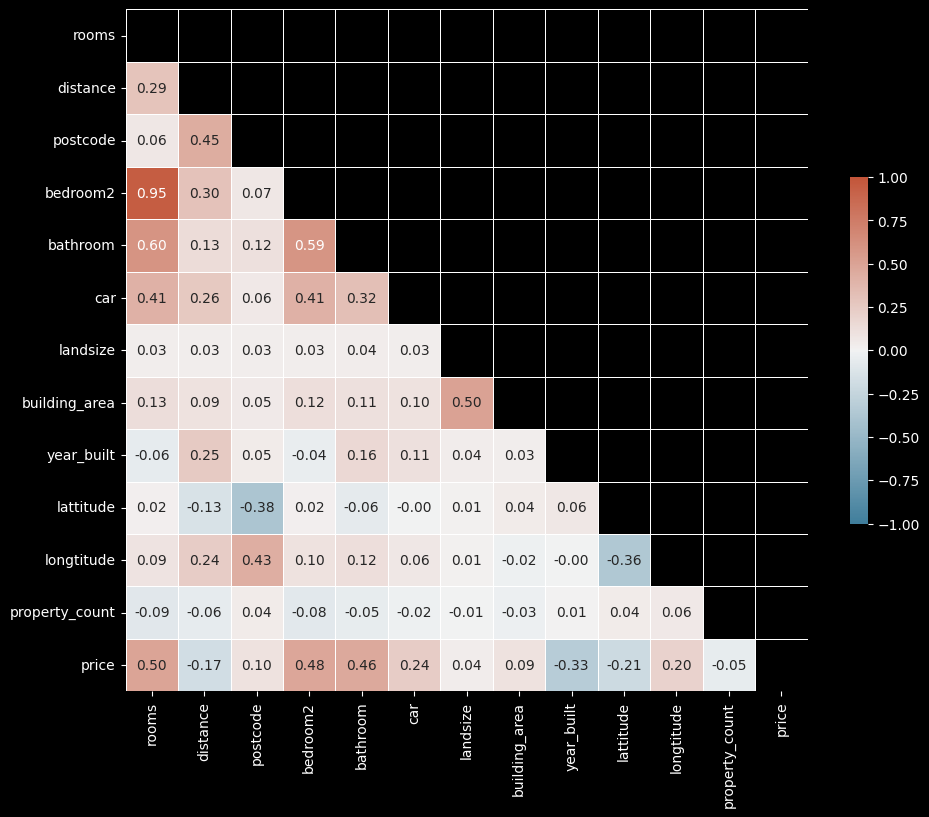

In [59]:
corr = train[X].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt = '.2f')

In [60]:
test.dropna(axis=1).columns

Index(['suburb', 'address', 'rooms', 'type', 'method', 'seller_g', 'date',
       'id'],
      dtype='object')

In [61]:
 train.sample(15, random_state=42).T

,14655,17371,2874,14844,8866,16049,6423,3942,2608,13488,12478,9857,1747,2518,2008
suburb,Aspendale Gardens,Carnegie,Eaglemont,Mount Waverley,Hawthorn East,Kingsville,Reservoir,Hampton,Coburg,Williamstown North,Bentleigh East,Doncaster,Brunswick,Coburg,Burwood
address,12 Pacific Dr,52 Tranmere Av,20 Glenard Dr,4 William St,218/12 Albert St,4/22 Edgar St,5 Queen St,2/22 Fewster Rd,15 Hardwick St,6 Edina St,7A Stockdale Av,39 Kiewa St,3 Ballarat St,1/58 Moore St,5 Keogh St
rooms,4,4,4,4,1,3,2,3,5,3,4,3,1,2,3
type,h,h,h,h,u,u,h,h,h,h,t,h,t,t,h
price,840000.0,1966000.0,2309000.0,1750000.0,375000.0,712000.0,931000.0,1105000.0,1020000.0,862000.0,1430000.0,1542000.0,625000.0,807000.0,1070500.0
method,VB,VB,S,SP,PI,S,S,S,PI,SP,S,S,PI,S,SP
seller_g,Barry,Ray,Nelson,Jellis,hockingstuart,Jas,Barry,hockingstuart,Raine,Greg,McGrath,Barry,Jellis,Nelson,Buxton
date,22/07/2017,23/09/2017,28/08/2016,22/07/2017,22/05/2016,9/09/2017,4/03/2017,28/05/2016,25/02/2017,27/05/2017,24/06/2017,8/04/2017,18/06/2016,3/12/2016,14/05/2016
distance,21.5,10.1,10.3,14.2,7.5,6.4,11.2,13.7,7.8,6.8,13.8,13.9,5.2,7.8,11.7
postcode,3195.0,3163.0,3084.0,3149.0,3123.0,3012.0,3073.0,3188.0,3058.0,3016.0,3165.0,3108.0,3056.0,3058.0,3125.0


## Столбец 'address'

По факту в адресе у нас лежат чистые адреса и для модели они не будут иметь никакого смысла. Выделим оттуда названия улиц. Возможно получится уловить зависимость по цене в зависимости от улицы, на котором находится дом.

In [62]:
train[['house','street']] = train['address'].str.split(' ', n=1, expand=True)
# train['street'] = train['address'].str.split(' ', n=1, expand=True)[1] #.rename({0: 'house', 1: 'street'}, axis = 1)

In [63]:
train['street'].sort_values()

15637    9 Somers Av
13293    Aanensen Ct
11986     Abassia St
817       Abassia St
15161       Abbey Al
            ...     
17954       moona Ct
10053      morang Rd
7649     robinson St
7036      thomson St
7037      webster St
Name: street, Length: 18373, dtype: object

In [64]:
train[train['address'].str.contains('Somers Av')]

,suburb,address,rooms,type,price,method,seller_g,date,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,property_count,id,house,street
14816,MacLeod,73 Somers Av,3,h,910000.0,S,Ray,22/07/2017,12.7,3085.0,NaN,NaN,NaN,NaN,NaN,NaN,Banyule City Council,NaN,NaN,Northern Metropolitan,4168.0,2669,73,Somers Av
15637,Malvern,3/101 9 Somers Av,3,u,2210000.0,S,Marshall,3/09/2017,5.9,3144.0,NaN,NaN,NaN,NaN,NaN,NaN,Stonnington City Council,NaN,NaN,Southern Metropolitan,4675.0,11875,3/101,9 Somers Av


In [65]:
display(train['street'].sort_values().head())
display(train['street'].nunique())
print(train['street'].str.lower().nunique())

train['street'] = train['street'].str.lower()

15637    9 Somers Av
13293    Aanensen Ct
11986     Abassia St
817       Abassia St
15161       Abbey Al
Name: street, dtype: object

6898

6890


In [66]:
train.loc[15637,['street']] = 'Somers Av'

In [67]:
train['house'].head()

0     85
1     25
2      5
3     40
4    55a
Name: house, dtype: object

In [68]:
print(train['house'].nunique())
print(train['house'].str.lower().nunique())

train['house'] = train['house'].str.lower()

4702    1
9560    1
9599    1
9605    1
4284    1
Name: house, dtype: object

3730
3636


Делаем такой же признак для тестовых данных

In [69]:
# test = test.join(test['address'].str.split(' ', n=1, expand=True).rename({0: 'house', 1: 'street'}, axis = 1))

test[['house','street']] = test['address'].str.split(' ', n=1, expand=True)

In [70]:
test['street'].sort_values()

7814     Aanensen Ct
1384    Abbeygate St
3124        Abbin Av
5114        Abbin Av
8155        Abbin Av
            ...     
5165         Zara Cl
6684        Zarro St
6612       Zenith St
7813      Zetland Rd
2396         lyon Rd
Name: street, Length: 8818, dtype: object

In [71]:
print(test['street'].nunique())
print(test['street'].str.lower().nunique())

test['street']=test['street'].str.lower()

5344
5343


In [72]:
print(test['house'].nunique())
print(test['house'].str.lower().nunique())
test['house']=test['house'].str.lower()

1900
1852


## Столбец `suburb`

In [73]:
train['suburb'].nunique()

329

In [74]:
train['suburb'].str.lower().nunique()

328

In [75]:
test['suburb'].nunique()

332

In [76]:
test['suburb'].str.lower().nunique()

331

In [77]:
train['suburb'] = train['suburb'].str.lower()
test['suburb'] = test['suburb'].str.lower()

Привели все названия микрорайонов в нижний регистр. Убрали одно неуникальное значение. В дальнейшем это нам поможет при группировках.

## Столбцы 'region_name', 'property_count', 'council_area'

In [78]:
train[train['region_name'].isna()|train['property_count'].isna()|train['council_area'].isna()]

,suburb,address,rooms,type,price,method,seller_g,date,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,property_count,id,house,street
14406,footscray,2/16 Stafford St,2,u,710000.0,S,Jas,15/07/2017,5.1,3011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21235,2/16,stafford st


In [79]:
test[test['region_name'].isna()|test['property_count'].isna()|test['council_area'].isna()]

,suburb,address,rooms,type,method,seller_g,date,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,property_count,id,house,street
2634,camberwell,2/3 Kingsley St,2,h,VB,Jellis,11/11/2017,7.7,3124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15921,2/3,kingsley st
4628,fawkner lot,1/3 Brian St,3,h,SP,Brad,6/01/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33262,1/3,brian st


In [171]:
test.query('suburb == "сamberwell" or suburb == "аawkner"').groupby(['suburb','region_name','council_area','property_count'])['suburb'].count()

Series([], Name: suburb, dtype: int64)

In [81]:
test.loc[2634,['region_name','council_area','property_count']] = ['Southern Metropolitan','Boroondara City Council',8920.0]
test.loc[4628,['region_name','council_area','property_count']] = ['Northern Metropolitan', 'Hume City Council', 5070.0]

Видим, что у нас попала одна строчка с где region_name, property_count, council_area равны нулю. Удалим эту строчку из выборки.

In [82]:
train = train.dropna(subset=['region_name', 'property_count', 'council_area'])

In [83]:
len(train)

18372

In [84]:
train.isna().sum().sort_values(ascending = False)

building_area     10622
year_built         9428
landsize           4793
car                3574
bathroom           3469
bedroom2           3467
longtitude         3331
lattitude          3331
house                 0
id                    0
property_count        0
region_name           0
council_area          0
suburb                0
address               0
postcode              0
distance              0
date                  0
seller_g              0
method                0
price                 0
type                  0
rooms                 0
street                0
dtype: int64

In [85]:
test.isna().sum().sort_values(ascending = False)

building_area     5936
year_built        5706
landsize          4453
car               3236
bathroom          2964
bedroom2          2960
longtitude        2910
lattitude         2910
distance             1
postcode             1
council_area         0
house                0
id                   0
property_count       0
region_name          0
suburb               0
address              0
date                 0
seller_g             0
method               0
type                 0
rooms                0
street               0
dtype: int64

## Столбец `postcode`

In [86]:
train['postcode'].info()

<class 'pandas.core.series.Series'>
Int64Index: 18372 entries, 0 to 18372
Series name: postcode
Non-Null Count  Dtype  
--------------  -----  
18372 non-null  float64
dtypes: float64(1)
memory usage: 287.1 KB


In [87]:
train['postcode'] = train['postcode'].astype('int')

Почтовые коды у нас заполнены хорошо, так что преобразуем их сразу в int.

Теперь посмотрим, что у нас с данными для теста.

In [88]:
test[test['postcode'].isna()]['suburb']

4628    fawkner lot
Name: suburb, dtype: object

Есть запись с пропущенным кодом. Попробую заполнить.

In [89]:
test[test['address'].str.contains('Brian St')]

,suburb,address,rooms,type,method,seller_g,date,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,property_count,id,house,street
4628,fawkner lot,1/3 Brian St,3,h,SP,Brad,6/01/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hume City Council,NaN,NaN,Northern Metropolitan,5070.0,33262,1/3,brian st
7171,mitcham,1 Brian St,3,h,S,Philip,17/02/2018,17.2,3132.0,3.0,1.0,1.0,630.0,110.0,1950.0,Whitehorse City Council,-37.82505,145.18797,Eastern Metropolitan,6871.0,22739,1,brian st


In [90]:
train[train['address'].str.contains('Brian St')]

,suburb,address,rooms,type,price,method,seller_g,date,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,property_count,id,house,street
1121,bentleigh east,1A Brian St,4,t,1185000.0,S,hockingstuart,10/12/2016,13.9,3165,4.0,2.0,2.0,305.0,207.0,2012.0,Glen Eira City Council,-37.9245,145.0507,Southern Metropolitan,10969.0,13328,1a,brian st
8750,fawkner,3 Brian St,3,h,625000.0,S,Brad,10/12/2016,12.4,3060,3.0,1.0,2.0,585.0,88.0,1960.0,Hume City Council,-37.6950,144.9676,Northern Metropolitan,5070.0,24826,3,brian st
9907,fawkner,3 Brian St,3,h,660000.0,S,Brad,8/04/2017,12.4,3060,3.0,1.0,2.0,585.0,88.0,1960.0,Hume City Council,-37.6950,144.9676,Northern Metropolitan,5070.0,20675,3,brian st


In [172]:
test[test['suburb'].str.contains('^fawkner.*', regex = True)].head()

,suburb,address,rooms,type,method,seller_g,date,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,property_count,id,house,street,median_year_built,median_year_built_council,median_year_built_council_type,year_built_filled
161,fawkner,8 Hare St,3,h,S,hockingstuart,2017-10-07,13.1,3060,3.0,1.0,2,681.0,NaN,NaN,Hume City Council,-37.70697,144.97966,Northern Metropolitan,5070.0,5952,8,hare st,1960.0,1994.0,1990.0,1990
674,fawkner,31 Major Rd,3,h,S,Stockdale,2017-10-14,13.1,3060,3.0,1.0,3,570.0,126.0,1968.0,Hume City Council,-37.70807,144.97282,Northern Metropolitan,5070.0,22519,31,major rd,1960.0,1994.0,1990.0,1968
675,fawkner,34 Marlborough St,3,h,PI,Brad,2017-10-14,13.1,3060,3.0,1.0,0,641.0,NaN,1950.0,Hume City Council,-37.71844,144.97038,Northern Metropolitan,5070.0,22087,34,marlborough st,1960.0,1994.0,1990.0,1950
676,fawkner,22 Sandra Av,3,h,S,Brad,2017-10-14,13.1,3060,3.0,1.0,1,671.0,109.0,1960.0,Hume City Council,-37.69571,144.96064,Northern Metropolitan,5070.0,19720,22,sandra av,1960.0,1994.0,1990.0,1960
1222,fawkner,3/1 Clara St,2,u,S,Ray,2017-10-21,13.1,3060,3.0,2.0,1,NaN,122.0,2011.0,Hume City Council,-37.71006,144.96306,Northern Metropolitan,5070.0,32839,3/1,clara st,1990.0,1994.0,1993.5,2011


In [173]:
train[train['suburb'].str.contains('^fawkner.*', regex = True)].head()

,suburb,address,rooms,type,price,method,seller_g,date,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,property_count,id,house,street,median_year_built,median_year_built_council,median_year_built_council_type,year_built_filled
8733,fawkner,3 Lovely St,3,h,670000.0,S,YPA,2016-12-03,12.4,3060,3.0,1.0,3,587.0,136.0,NaN,Hume City Council,-37.7007,144.9632,Northern Metropolitan,5070.0,10826,3,lovely st,1960.0,1994.0,1990.0,1990
8734,fawkner,220 McBryde St,3,h,645000.0,SP,YPA,2016-02-04,12.4,3060,3.0,1.0,4,661.0,NaN,NaN,Hume City Council,-37.7009,144.9776,Northern Metropolitan,5070.0,33834,220,mcbryde st,1960.0,1994.0,1990.0,1990
8735,fawkner,73 Argyle St,3,h,687000.0,S,YPA,2017-03-04,12.4,3060,3.0,1.0,0,684.0,NaN,NaN,Hume City Council,-37.7174,144.9664,Northern Metropolitan,5070.0,26369,73,argyle st,1960.0,1994.0,1990.0,1990
8736,fawkner,1/71 Lynch Rd,2,u,333000.0,SP,hockingstuart,2017-03-04,12.4,3060,2.0,1.0,1,97.0,79.0,1970.0,Hume City Council,-37.7118,144.9689,Northern Metropolitan,5070.0,15005,1/71,lynch rd,1990.0,1994.0,1993.5,1970
8737,fawkner,2A Piper St,3,t,455000.0,S,Brad,2017-03-04,12.4,3060,3.0,2.0,1,738.0,138.0,2010.0,Hume City Council,-37.7109,144.9654,Northern Metropolitan,5070.0,18581,2a,piper st,2008.0,1994.0,2010.5,2010


In [93]:
test.loc[4628,'postcode']

nan

In [94]:
test.loc[4628,'postcode'] = 3060

In [174]:
test.loc[4628,'suburb']

'Fawkner'

Удостоверился, что это опечатка, заменю на правильное название.

In [175]:
test.loc[4628,'suburb'] = 'fawkner'

In [176]:
test.loc[4628]

suburb                                          fawkner
address                                    1/3 Brian St
rooms                                                 3
type                                                  h
method                                               SP
seller_g                                           Brad
date                                2018-01-06 00:00:00
distance                                           13.1
postcode                                           3060
bedroom2                                            NaN
bathroom                                            NaN
car                                                   0
landsize                                            NaN
building_area                                       NaN
year_built                                          NaN
council_area                          Hume City Council
lattitude                                    -37.694889
longtitude                                   144

In [98]:
test['postcode'] = test['postcode'].astype('int')

Также поменяли тип данных на int для тестовых данных

## Столбец `car`

In [99]:
train['car'].nunique()

11

In [100]:
test['car'].nunique()

13

In [101]:
train['car'].value_counts(dropna=False)

2.0     6181
1.0     6058
NaN     3574
0.0     1050
3.0      808
4.0      549
5.0       66
6.0       62
8.0       12
7.0        8
10.0       3
9.0        1
Name: car, dtype: int64

In [102]:
train['car'] = train['car'].fillna(0)

In [103]:
test['car'].value_counts(dropna=False)

NaN     3236
2.0     3176
1.0     1324
3.0      424
4.0      353
0.0      194
5.0       46
6.0       43
7.0       11
8.0        6
10.0       2
18.0       1
11.0       1
9.0        1
Name: car, dtype: int64

In [104]:
test['car'] = test['car'].fillna(0)

## Столбец `year_build`

In [105]:
len(train)

18372

In [106]:
train.isna().sum().sort_values(ascending=False)

building_area     10622
year_built         9428
landsize           4793
bathroom           3469
bedroom2           3467
longtitude         3331
lattitude          3331
suburb                0
house                 0
id                    0
property_count        0
region_name           0
council_area          0
car                   0
address               0
postcode              0
distance              0
date                  0
seller_g              0
method                0
price                 0
type                  0
rooms                 0
street                0
dtype: int64

In [107]:
train['year_built'].isna().sum()

9428

In [108]:
train['year_built'].describe()

count    8944.000000
mean     1965.925089
std        36.958956
min      1196.000000
25%      1950.000000
50%      1970.000000
75%      2000.000000
max      2018.000000
Name: year_built, dtype: float64

<Axes: >

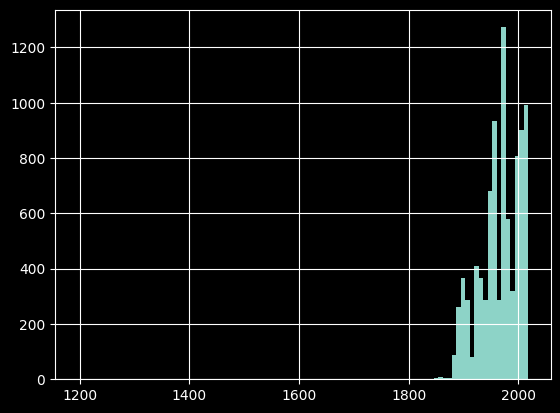

In [179]:
train['year_built'].hist(bins = 100, grid = True)

<Axes: >

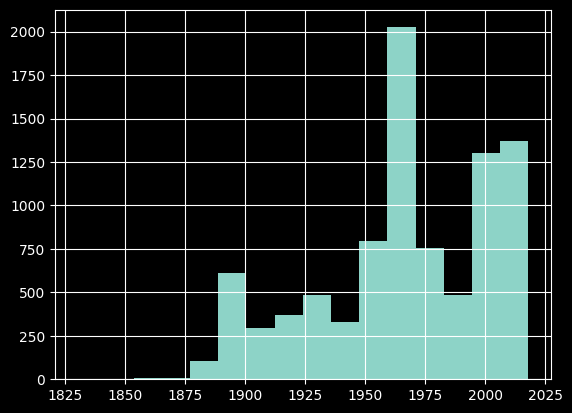

In [110]:
train[train['year_built'].between(1830,2100)]['year_built'].hist(bins = 16)

In [111]:
train.groupby('suburb',dropna=False)['year_built'].agg(['count','median','mean']).sort_values('count').head(50)

,count,median,mean
suburb,,,
monbulk,0,NaN,NaN
bullengarook,0,NaN,NaN
werribee south,0,NaN,NaN
patterson lakes,0,NaN,NaN
clyde north,0,NaN,NaN
plenty,0,NaN,NaN
cranbourne east,0,NaN,NaN
silvan,0,NaN,NaN
docklands,0,NaN,NaN


In [112]:
train.groupby('region_name',dropna=False)['year_built'].agg(['count','median','mean']).sort_values('count')

,count,median,mean
region_name,,,
Western Victoria,29,1980.0,1981.000000
Northern Victoria,35,1988.0,1989.771429
Eastern Victoria,37,1980.0,1986.270270
South-Eastern Metropolitan,321,1975.0,1977.482866
Eastern Metropolitan,932,1970.0,1972.834764
Western Metropolitan,1899,1970.0,1969.295945
Northern Metropolitan,2598,1970.0,1964.213241
Southern Metropolitan,3093,1965.0,1961.357258


In [113]:
test.isna().sum().sort_values(ascending = False)

building_area     5936
year_built        5706
landsize          4453
bathroom          2964
bedroom2          2960
longtitude        2910
lattitude         2910
distance             1
suburb               0
house                0
id                   0
property_count       0
region_name          0
council_area         0
car                  0
address              0
postcode             0
date                 0
seller_g             0
method               0
type                 0
rooms                0
street               0
dtype: int64

In [114]:
test.groupby('region_name',dropna=False)['year_built'].agg(['count','median','mean']).sort_values('count')

,count,median,mean
region_name,,,
Western Victoria,34,1975.0,1977.352941
Eastern Victoria,39,1990.0,1987.846154
Northern Victoria,55,2004.0,1997.327273
South-Eastern Metropolitan,234,1975.0,1977.794872
Eastern Metropolitan,432,1972.0,1974.025463
Southern Metropolitan,631,1950.0,1952.354992
Western Metropolitan,762,1983.5,1975.160105
Northern Metropolitan,925,1975.0,1967.087568


In [115]:
full_data = pd.concat([train[['type','region_name', 'year_built','suburb','council_area']], test[['type','region_name', 'year_built','suburb','council_area']]])

In [116]:
full_data.groupby(['region_name','council_area','type'],dropna=False)['year_built'].agg(['count','max','min','median','mean']).sort_values('count').sort_values(['region_name', 'council_area','type'])

count     max     min  \
region_name          council_area            type                          
Eastern Metropolitan Banyule City Council    h       320  2017.0  1905.0   
                                             t        40  2016.0  1950.0   
                                             u        58  2015.0  1960.0   
                     Boroondara City Council h        17  2000.0  1880.0   
                                             t         3  2001.0  2000.0   
...                                                  ...     ...     ...   
Western Metropolitan Wyndham City Council    t         1  2006.0  2006.0   
                                             u         6  2013.0  1987.0   
Western Victoria     Melton City Council     h        61  2016.0  1960.0   
                                             u         0     NaN     NaN   
                     Moorabool Shire Council h         2  1990.0  1956.0   

                                                   median         mean  
region_name          council_area            type                       
Eastern Metropolitan Banyule City Council    h     1960.0  1963.684375  
                                             t     2003.0  1996.750000  
                                             u     1974.5  1979.310345  
                     Boroondara City Council h     1938.0  1937.411765  
                                             t     2000.0  2000.333333  
...                                                   ...          ...  
Western Metropolitan Wyndham City Council    t     2006.0  2006.000000  
                                             u     1998.0  1999.333333  
Western Victoria     Melton City Council     h     1975.0  1979.229508  
                                             u        NaN          NaN  
                     Moorabool Shire Council h     1973.0  1973.000000  

[127 rows x 5 columns]

In [117]:
median_year_built = full_data.groupby(['region_name','type'],dropna=False)['year_built'].agg(['median']).reset_index()

median_year_built_per_council_area = full_data.groupby(['region_name','council_area'],dropna=False)['year_built'].agg(['median'])

median_year_built_per_council_area_x_type = full_data.groupby(['region_name','council_area','type'],dropna=False)['year_built'].agg(['median'])



In [118]:
train.council_area.nunique()

33

In [119]:
train = train.merge(median_year_built, how = 'left', on = ['region_name','type']).rename({'median': 'median_year_built'},axis = 1)
train = train.merge(median_year_built_per_council_area, how = 'left', on = ['region_name','council_area']).rename({'median': 'median_year_built_council'},axis = 1)
train = train.merge(median_year_built_per_council_area_x_type, how = 'left', on = ['region_name','council_area','type']).rename({'median': 'median_year_built_council_type'},axis = 1)

In [120]:
test = test.merge(median_year_built, how = 'left', on = ['region_name','type']).rename({'median': 'median_year_built'},axis = 1)
test = test.merge(median_year_built_per_council_area, how = 'left', on = ['region_name','council_area']).rename({'median': 'median_year_built_council'},axis = 1)
test = test.merge(median_year_built_per_council_area_x_type, how = 'left', on = ['region_name','council_area','type']).rename({'median': 'median_year_built_council_type'},axis = 1)


In [121]:
train['median_year_built_council_type'].isna().sum()

1

In [122]:
train[train['median_year_built_council_type'].isna()]

,suburb,address,rooms,type,price,method,seller_g,date,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,property_count,id,house,street,median_year_built,median_year_built_council,median_year_built_council_type
15000,beaconsfield,2 George St,3,u,537000.0,S,Peake,29/07/2017,39.0,3807,3.0,1.0,1.0,460.0,NaN,NaN,Cardinia Shire Council,-38.04668,145.36939,Eastern Victoria,2332.0,8880,2,george st,2007.0,2004.5,NaN


In [180]:
pd.concat([test[test['suburb']== 'beaconsfield'],train[train['suburb']== 'beaconsfield']])

,suburb,address,rooms,type,method,seller_g,date,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,property_count,id,house,street,median_year_built,median_year_built_council,median_year_built_council_type,year_built_filled,price
14665,beaconsfield,12 Windsor Dr,4,h,SP,Harcourts,2017-07-22,39.0,3807,4.0,2.0,2,900.0,244.0,2005.0,Cardinia Shire Council,-38.05614,145.38464,Eastern Victoria,2332.0,26911,12,windsor dr,1980.0,2004.5,2004.5,2005,670000.0
15000,beaconsfield,2 George St,3,u,S,Peake,2017-07-29,39.0,3807,3.0,1.0,1,460.0,NaN,NaN,Cardinia Shire Council,-38.04668,145.36939,Eastern Victoria,2332.0,8880,2,george st,2007.0,2004.5,NaN,2007,537000.0


In [124]:
test['median_year_built_council_type'].isna().sum()

7

In [125]:
test['median_year_built'].isna().sum()

3

In [126]:
test['median_year_built_council'].isna().sum()

0

In [127]:
# train[train['year_built'].isna()].groupby(['region_name','type'])['type'].agg(['count'])

Заполним наши года постройки по типу зданий и району.

In [128]:
train['year_built_filled'] = train[['year_built', 'median_year_built_council_type', 'median_year_built', 'median_year_built_council']].bfill(axis=1).iloc[:, 0]

In [129]:
test['year_built_filled'] = test[['year_built', 'median_year_built_council_type', 'median_year_built', 'median_year_built_council']].bfill(axis=1).iloc[:, 0]

In [130]:
train.year_built_filled.isna().sum()

0

In [131]:
test.year_built_filled.isna().sum()

0

## Столбец distance

In [132]:
train['distance'].info()

<class 'pandas.core.series.Series'>
Int64Index: 18372 entries, 0 to 18371
Series name: distance
Non-Null Count  Dtype  
--------------  -----  
18372 non-null  float64
dtypes: float64(1)
memory usage: 287.1 KB


In [133]:
test[test['distance'].isna()]

,suburb,address,rooms,type,method,seller_g,date,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,property_count,id,house,street,median_year_built,median_year_built_council,median_year_built_council_type,year_built_filled
4628,Fawkner,1/3 Brian St,3,h,SP,Brad,6/01/2018,NaN,3060,NaN,NaN,0.0,NaN,NaN,NaN,Hume City Council,NaN,NaN,Northern Metropolitan,5070.0,33262,1/3,brian st,1960.0,1994.0,1990.0,1990.0


In [181]:
test[test['suburb'] == 'fawkner'].groupby('suburb', dropna = False)['distance'].agg(['count', 'mean', 'median'])

,count,mean,median
suburb,,,
fawkner,55,13.1,13.1


In [135]:
test['distance'] = test['distance'].fillna(13.1)

In [136]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8818 entries, 0 to 8817
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   suburb                          8818 non-null   object 
 1   address                         8818 non-null   object 
 2   rooms                           8818 non-null   int64  
 3   type                            8818 non-null   object 
 4   method                          8818 non-null   object 
 5   seller_g                        8818 non-null   object 
 6   date                            8818 non-null   object 
 7   distance                        8818 non-null   float64
 8   postcode                        8818 non-null   int64  
 9   bedroom2                        5858 non-null   float64
 10  bathroom                        5854 non-null   float64
 11  car                             8818 non-null   float64
 12  landsize                        43

## Столбец `bedroom2`

Количество спален.

У нас есть переменная - количество комнат rooms, а это отдельно спальни.

In [137]:
train['bedroom2'].describe()

count    14905.000000
mean         2.914928
std          0.962743
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max         20.000000
Name: bedroom2, dtype: float64

In [138]:
train['bedroom2'].isna().sum()

3467

In [139]:
train['bedroom2'].value_counts()

3.0     6466
2.0     4122
4.0     2863
1.0      745
5.0      601
6.0       69
0.0       16
7.0       12
8.0        6
9.0        3
20.0       1
10.0       1
Name: bedroom2, dtype: int64

In [140]:
train.groupby(['type','rooms','bedroom2'],dropna=False)['rooms'].agg(['count','mean','median'])

count  mean  median
type rooms bedroom2                     
h    1     1.0          55   1.0     1.0
           2.0           2   1.0     1.0
           3.0           2   1.0     1.0
           NaN          11   1.0     1.0
     2     0.0           1   2.0     2.0
...                    ...   ...     ...
u    4     5.0           1   4.0     4.0
           NaN           8   4.0     4.0
     6     4.0           1   6.0     6.0
     8     4.0           1   8.0     8.0
           NaN           1   8.0     8.0

[92 rows x 3 columns]

In [141]:
train.isna().sum().sort_values(ascending = False)

building_area                     10622
year_built                         9428
landsize                           4793
bathroom                           3469
bedroom2                           3467
longtitude                         3331
lattitude                          3331
median_year_built_council_type        1
council_area                          0
median_year_built_council             0
median_year_built                     0
street                                0
house                                 0
id                                    0
property_count                        0
region_name                           0
suburb                                0
address                               0
car                                   0
postcode                              0
distance                              0
date                                  0
seller_g                              0
method                                0
price                                 0


In [142]:
train[train['bedroom2'].isna()].sample(15)

,suburb,address,rooms,type,price,method,seller_g,date,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,property_count,id,house,street,median_year_built,median_year_built_council,median_year_built_council_type,year_built_filled
5351,moorabbin,610/6 Station St,2,u,460000.0,PI,Ray,24/09/2016,14.6,3189,NaN,NaN,0.0,NaN,NaN,NaN,Kingston City Council,NaN,NaN,Southern Metropolitan,2555.0,21913,610/6,station st,1970.0,1960.0,1975.0,1975.0
8666,carlton,14/357 Rathdowne St,2,u,660000.0,S,Nelson,13/08/2016,1.8,3053,NaN,NaN,0.0,NaN,NaN,NaN,Melbourne City Council,NaN,NaN,Northern Metropolitan,6786.0,4867,14/357,rathdowne st,1990.0,1970.0,1998.0,1998.0
14983,alphington,1/16 Miller St,3,h,1305000.0,PI,Jellis,29/07/2017,5.7,3078,NaN,NaN,0.0,NaN,NaN,NaN,Darebin City Council,NaN,NaN,Northern Metropolitan,2211.0,8537,1/16,miller st,1960.0,1960.0,1945.0,1945.0
10679,sunshine north,4 Godfrey Av,3,h,660000.0,PI,Bells,8/04/2017,13.3,3020,NaN,NaN,0.0,NaN,NaN,NaN,Brimbank City Council,NaN,NaN,Western Metropolitan,4217.0,8790,4,godfrey av,1970.0,1980.0,1975.0,1975.0
2679,coburg north,17 Glyndon Av,3,h,835500.0,S,Walshe,13/08/2016,9.2,3058,NaN,NaN,0.0,NaN,NaN,NaN,Darebin City Council,NaN,NaN,Northern Metropolitan,3445.0,2853,17,glyndon av,1960.0,1960.0,1945.0,1945.0
7625,sunshine,22 Andrew St,4,h,810000.0,PI,Douglas,19/11/2016,12.6,3020,NaN,NaN,0.0,NaN,NaN,NaN,Brimbank City Council,-37.7806,144.8413,Western Metropolitan,3755.0,34084,22,andrew st,1970.0,1980.0,1975.0,1975.0
7774,sunshine west,32 Buckingham Cr,4,h,451500.0,S,Barry,22/08/2016,13.5,3020,NaN,NaN,0.0,NaN,NaN,NaN,Brimbank City Council,NaN,NaN,Western Metropolitan,6763.0,8920,32,buckingham cr,1970.0,1980.0,1975.0,1975.0
5605,northcote,20 Oldis Av,3,h,1280000.0,S,Barry,7/05/2016,5.5,3070,NaN,NaN,0.0,NaN,NaN,NaN,Darebin City Council,NaN,NaN,Northern Metropolitan,11364.0,23793,20,oldis av,1960.0,1960.0,1945.0,1945.0
12810,seaford,21 Keerok Av,3,h,585000.0,SA,Buxton,24/06/2017,35.4,3198,NaN,NaN,0.0,NaN,NaN,NaN,Frankston City Council,NaN,NaN,South-Eastern Metropolitan,8077.0,19897,21,keerok av,1975.0,1970.5,1970.0,1970.0
10950,kensington,15 Taylor Mw,2,t,717000.0,S,Nelson,20/05/2017,4.2,3031,NaN,NaN,0.0,NaN,NaN,NaN,Melbourne City Council,NaN,NaN,Northern Metropolitan,5263.0,19263,15,taylor mw,2008.0,1970.0,1999.5,1999.5


In [143]:
train[train['bedroom2']>train['rooms']]

,suburb,address,rooms,type,price,method,seller_g,date,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,property_count,id,house,street,median_year_built,median_year_built_council,median_year_built_council_type,year_built_filled
6,abbotsford,124 Yarra St,3,h,1876000.0,S,Nelson,7/05/2016,2.5,3067,4.0,2.0,0.0,245.0,210.0,1910.0,Yarra City Council,-37.80240,144.99930,Northern Metropolitan,4019.0,18292,124,yarra st,1960.0,1950.0,1900.0,1910.0
11,abbotsford,10 Valiant St,2,h,1097000.0,S,Biggin,8/10/2016,2.5,3067,3.0,1.0,2.0,220.0,75.0,1900.0,Yarra City Council,-37.80100,144.99890,Northern Metropolitan,4019.0,18730,10,valiant st,1960.0,1950.0,1900.0,1900.0
91,airport west,6 Kittyhawk St,4,h,773000.0,S,Brad,17/09/2016,13.5,3042,5.0,3.0,4.0,531.0,309.0,1980.0,Moonee Valley City Council,-37.72630,144.86790,Western Metropolitan,3464.0,29842,6,kittyhawk st,1970.0,1966.0,1950.0,1980.0
290,altona north,1/156 Chambers Rd,3,h,620000.0,SP,Hunter,22/08/2016,11.1,3025,5.0,2.0,2.0,276.0,100.0,2010.0,Hobsons Bay City Council,-37.82620,144.84430,Western Metropolitan,5132.0,23108,1/156,chambers rd,1970.0,1970.0,1961.0,2010.0
327,armadale,11/17 Myamyn St,2,u,3625000.0,S,Jellis,4/06/2016,6.3,3143,3.0,2.0,2.0,0.0,NaN,2006.0,Stonnington City Council,-37.85550,145.02910,Southern Metropolitan,4836.0,12643,11/17,myamyn st,1970.0,1951.0,1970.0,2006.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14951,toorak,10/270 Williams Rd,1,u,350000.0,VB,Marshall,22/07/2017,4.1,3142,2.0,1.0,1.0,0.0,NaN,1970.0,Stonnington City Council,-37.84157,145.00469,Southern Metropolitan,7217.0,13488,10/270,williams rd,1970.0,1951.0,1970.0,1970.0
15773,thornbury,316 Rossmoyne St,3,h,1375000.0,S,McGrath,3/09/2017,7.0,3071,4.0,2.0,3.0,530.0,145.0,1950.0,Darebin City Council,-37.75968,145.02305,Northern Metropolitan,8870.0,1486,316,rossmoyne st,1960.0,1960.0,1945.0,1950.0
16878,broadmeadows,7 Osway St,2,h,625000.0,S,Nicholson,19/08/2017,14.0,3047,3.0,1.0,2.0,NaN,75.0,1960.0,Hume City Council,-37.69240,144.91733,Northern Metropolitan,4294.0,11065,7,osway st,1960.0,1994.0,1990.0,1960.0
16896,burwood east,61 Newhaven Rd,3,h,1000000.0,VB,Fletchers,19/08/2017,14.7,3151,4.0,2.0,2.0,788.0,108.0,1960.0,Whitehorse City Council,-37.85985,145.15656,Eastern Metropolitan,4048.0,10308,61,newhaven rd,1970.0,1970.0,1965.0,1960.0


Видим довольно забавную ситуацию. В нашей выборке присутствуют данные где количество спальных комнат превышает в целом количество комнат.  
И тут, честно говоря непонятно чему верить и как заполнять.

## Столбец `seller_g`

In [144]:
sorted(train['seller_g'].unique())

['@Realty',
 'AIME',
 'ASL',
 "Abercromby's",
 'Ace',
 'Airport',
 'Alexkarbon',
 'Allan',
 'Allens',
 'Anderson',
 'Appleby',
 'Aquire',
 'Area',
 'Ascend',
 'Ash',
 'Asset',
 'Assisi',
 'Aumeca',
 'Australian',
 'Avion',
 'Barlow',
 'Barry',
 'Batty',
 'Bayside',
 'Bekdon',
 'Beller',
 'Bells',
 'Besser',
 'Better',
 'Biggin',
 'Black',
 'Blue',
 'Bombay',
 'Boran',
 'Boutique',
 'Bowman',
 'Brace',
 'Brad',
 'Buckingham',
 'Bullen',
 'Burnham',
 'Bustin',
 'Buxton',
 'Buxton/Advantage',
 'Buxton/Find',
 'C21',
 'CASTRAN',
 'Caine',
 'Calder',
 'Carter',
 'Castran',
 'Cayzer',
 'Century',
 'Chambers',
 'Changing',
 'Charlton',
 'Chisholm',
 'Christopher',
 'Clairmont',
 'Collings',
 'Collins',
 'Community',
 'Compton',
 'Conquest',
 'Considine',
 'Coventry',
 'Craig',
 'Crane',
 "D'Aprano",
 'Daniel',
 'Darras',
 'Darren',
 'David',
 'Del',
 'Dingle',
 'Direct',
 'Dixon',
 'Domain',
 'Donovan',
 'Douglas',
 'Edward',
 'Elite',
 'Eric',
 'Eview',
 'FN',
 'First',
 'Flannagan',
 'Fletc

В целом нормальный признак,

## Проверка на дубликаты.

In [145]:
train.duplicated().sum()

0

Дубликатов нет - это здорово.

## Преобразование типов данных

In [146]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18372 entries, 0 to 18371
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   suburb                          18372 non-null  object 
 1   address                         18372 non-null  object 
 2   rooms                           18372 non-null  int64  
 3   type                            18372 non-null  object 
 4   price                           18372 non-null  float64
 5   method                          18372 non-null  object 
 6   seller_g                        18372 non-null  object 
 7   date                            18372 non-null  object 
 8   distance                        18372 non-null  float64
 9   postcode                        18372 non-null  int64  
 10  bedroom2                        14905 non-null  float64
 11  bathroom                        14903 non-null  float64
 12  car                             

In [147]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8818 entries, 0 to 8817
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   suburb                          8818 non-null   object 
 1   address                         8818 non-null   object 
 2   rooms                           8818 non-null   int64  
 3   type                            8818 non-null   object 
 4   method                          8818 non-null   object 
 5   seller_g                        8818 non-null   object 
 6   date                            8818 non-null   object 
 7   distance                        8818 non-null   float64
 8   postcode                        8818 non-null   int64  
 9   bedroom2                        5858 non-null   float64
 10  bathroom                        5854 non-null   float64
 11  car                             8818 non-null   float64
 12  landsize                        43

In [148]:
train[train['address'].str.contains('Brian St')]

,suburb,address,rooms,type,price,method,seller_g,date,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,property_count,id,house,street,median_year_built,median_year_built_council,median_year_built_council_type,year_built_filled
1121,bentleigh east,1A Brian St,4,t,1185000.0,S,hockingstuart,10/12/2016,13.9,3165,4.0,2.0,2.0,305.0,207.0,2012.0,Glen Eira City Council,-37.9245,145.0507,Southern Metropolitan,10969.0,13328,1a,brian st,2002.0,1970.0,2006.0,2012.0
8750,fawkner,3 Brian St,3,h,625000.0,S,Brad,10/12/2016,12.4,3060,3.0,1.0,2.0,585.0,88.0,1960.0,Hume City Council,-37.6950,144.9676,Northern Metropolitan,5070.0,24826,3,brian st,1960.0,1994.0,1990.0,1960.0
9907,fawkner,3 Brian St,3,h,660000.0,S,Brad,8/04/2017,12.4,3060,3.0,1.0,2.0,585.0,88.0,1960.0,Hume City Council,-37.6950,144.9676,Northern Metropolitan,5070.0,20675,3,brian st,1960.0,1994.0,1990.0,1960.0


In [150]:
train['postcode'] = train['postcode'].astype('int')
train['car'] = train['car'].astype('int')
train['date'] = pd.to_datetime(train['date'], dayfirst=True)
train['year_built_filled'] = train['year_built_filled'].astype('int')

In [151]:
test['postcode'] = test['postcode'].astype('int')
test['car'] = test['car'].astype('int')
test['date'] = pd.to_datetime(test['date'], dayfirst=True)
test['year_built_filled'] = test['year_built_filled'].astype('int')

## Решение задачи с заполнением полей долготы и широты через API


In [152]:
import requests

url = "https://geocode.maps.co/search?street=85+Turner+St&city=Melbourne&postalcode=3067"

response = requests.get(url)

for place in response.json():
  a = place.get('lat'),place.get('lon')
  print(a)

('-37.7993152', '144.9975063')


In [153]:
train['address'].str.replace(' ','+').head(5)

0        85+Turner+St
1     25+Bloomburg+St
2        5+Charles+St
3    40+Federation+La
4         55a+Park+St
Name: address, dtype: object

In [154]:
import time

def get_lon_lat(row):
  time.sleep(0.5)
  ad = row['address'].replace(' ','+')
  #url = "https://geocode.maps.co/search?street=403/609+Victoria+St&city=Melbourne&postalcode=3067"
  url=f"https://geocode.maps.co/search?street={ad}&city=Melbourne&postalcode={row['postcode']}"
  try:
    response = requests.get(url).json()
  except:
    return None
  if len(response) == 0:
    return None
  else:
    return response[0].get('lat') + ';' + response[0].get('lon')

In [155]:
train[train['lattitude'].isna()][['address','postcode']].head()

,address,postcode
8,217 Langridge St,3067
9,18a Mollison St,3067
12,403/609 Victoria St,3067
13,25/84 Trenerry Cr,3067
14,106/119 Turner St,3067


In [158]:
# train_geocode = train.loc[train['lattitude'].isna(),['address','postcode']].apply(lambda row: get_lon_lat(row), axis = 1)
# train_geocode.str.split(';', expand = True).rename({0: 'lattitude', 1: 'longtitude'}, axis = 1).to_csv('/content/train_geocode.csv')

In [159]:
# test_geocode = test.loc[test['lattitude'].isna(),['address','postcode']].apply(lambda row: get_lon_lat(row), axis = 1)
# test_geocode.str.split(';', expand = True).rename({0: 'lattitude', 1: 'longtitude'}, axis = 1).to_csv('/content/test_geocode.csv')

Результаты выполнение моей самописной функции для нахождения lat и long записал в файлики, так как из-за ограничения количества запросов к api, отработка функции занимает около получаса. Результаты ниже.

test_geocode = https://drive.google.com/file/d/1SyMd9W9xF_bw8IwYi6go9DC5WHT8J9pc/view?usp=drive_link


train_geocode = https://drive.google.com/file/d/1O5Hu7dBMF2KxaTOvLSxOiBooEOkcEIpZ/view?usp=drive_link

In [157]:
!gdown 1SyMd9W9xF_bw8IwYi6go9DC5WHT8J9pc
!gdown 1O5Hu7dBMF2KxaTOvLSxOiBooEOkcEIpZ

Downloading...
From: https://drive.google.com/uc?id=1SyMd9W9xF_bw8IwYi6go9DC5WHT8J9pc
To: /content/test_geocode.csv
100% 84.0k/84.0k [00:00<00:00, 5.47MB/s]
Downloading...
From: https://drive.google.com/uc?id=1O5Hu7dBMF2KxaTOvLSxOiBooEOkcEIpZ
To: /content/train_geocode.csv
100% 94.9k/94.9k [00:00<00:00, 55.4MB/s]


In [160]:
train_geocode = pd.read_csv('/content/train_geocode.csv', index_col = 0)
test_geocode = pd.read_csv('/content/test_geocode.csv', index_col = 0)

In [161]:
train_geocode

,lattitude,longtitude
8,-37.807115,144.991480
9,-37.807130,144.995719
12,NaN,NaN
13,-37.795025,145.000926
14,-37.799315,144.997506
...,...,...
18359,-37.798574,144.888217
18360,-37.832461,145.165636
18361,-37.883665,145.167419
18364,-37.717143,145.039155


In [162]:
train_geocode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3331 entries, 8 to 18366
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   lattitude   3190 non-null   float64
 1   longtitude  3190 non-null   float64
dtypes: float64(2)
memory usage: 78.1 KB


In [163]:
len(test.loc[test['lattitude'].isna(),['address','postcode']])

2910

In [164]:
# train_geocode = train_geocode.str.split(';', expand = True).rename({0: 'lattitude', 1: 'longtitude'}, axis = 1)
# test_geocode = test_geocode.str.split(';', expand = True).rename({0: 'lattitude', 1: 'longtitude'}, axis = 1)

In [165]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8818 entries, 0 to 8817
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   suburb                          8818 non-null   object        
 1   address                         8818 non-null   object        
 2   rooms                           8818 non-null   int64         
 3   type                            8818 non-null   object        
 4   method                          8818 non-null   object        
 5   seller_g                        8818 non-null   object        
 6   date                            8818 non-null   datetime64[ns]
 7   distance                        8818 non-null   float64       
 8   postcode                        8818 non-null   int64         
 9   bedroom2                        5858 non-null   float64       
 10  bathroom                        5854 non-null   float64       
 11  car 

In [166]:
train.loc[train['lattitude'].isna(),['lattitude','longtitude']] = train_geocode[['lattitude','longtitude']]
train['lattitude'].isna().sum()

454

In [167]:
test.loc[test['lattitude'].isna(),['lattitude','longtitude']] = test_geocode[['lattitude','longtitude']]
test['lattitude'].isna().sum()

156

Так как у нас все же не все поля заполнились, найдем средние значения долготы и широты в разбиении микрорайон-район и с объединенной датой train и  test

In [168]:
full_data = pd.concat([train[['suburb', 'council_area','lattitude', 'longtitude']], test[['suburb', 'council_area','lattitude', 'longtitude']]])

In [169]:
mean_lat = full_data.groupby(['suburb','council_area'], dropna = False)['lattitude'].agg(['mean']).reset_index().rename({'mean': 'mean_lattitude'}, axis = 1)

mean_long = full_data.groupby(['suburb','council_area'], dropna = False)['longtitude'].agg(['mean']).reset_index().rename({'mean': 'mean_longtitude'}, axis = 1)

In [187]:
mean_lat[mean_lat['mean_lattitude'].isna()]

,suburb,council_area,mean_lattitude


In [188]:
mean_lat_long = mean_lat.merge(mean_long, on = ['suburb','council_area'], how = 'left')

In [189]:
mean_lat_long

,suburb,council_area,mean_lattitude,mean_longtitude
0,Fawkner,Hume City Council,-37.694889,144.968175
1,abbotsford,Yarra City Council,-37.804542,145.001602
2,aberfeldie,Moonee Valley City Council,-37.761916,144.899066
3,airport west,Moonee Valley City Council,-37.726120,144.882228
4,albanvale,Brimbank City Council,-37.745714,144.770653
...,...,...,...,...
338,wonga park,Manningham City Council,-37.745995,145.282280
339,wyndham vale,Wyndham City Council,-37.877532,144.620428
340,yallambie,Banyule City Council,-37.725892,145.095556
341,yarra glen,Yarra Ranges Shire Council,-37.653910,145.373890


In [190]:
train = train.merge(mean_lat_long, how='left', on = ['suburb','council_area'])
test = test.merge(mean_lat_long, how='left', on = ['suburb','council_area'])

In [191]:
train.head()

,suburb,address,rooms,type,price,method,seller_g,date,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,property_count,id,house,street,median_year_built,median_year_built_council,median_year_built_council_type,year_built_filled,mean_lattitude,mean_longtitude
0,abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-12-03,2.5,3067,2.0,1.0,1,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0,34302,85,turner st,1960.0,1950.0,1900.0,1900,-37.804542,145.001602
1,abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-02-04,2.5,3067,2.0,1.0,0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0,33247,25,bloomburg st,1960.0,1950.0,1900.0,1900,-37.804542,145.001602
2,abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-03-04,2.5,3067,3.0,2.0,0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0,31886,5,charles st,1960.0,1950.0,1900.0,1900,-37.804542,145.001602
3,abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-03-04,2.5,3067,3.0,2.0,1,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0,18999,40,federation la,1960.0,1950.0,1900.0,1900,-37.804542,145.001602
4,abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-06-04,2.5,3067,3.0,1.0,2,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0,16809,55a,park st,1960.0,1950.0,1900.0,2014,-37.804542,145.001602


In [195]:
train.mean_lattitude.isna().sum()

0

In [196]:
train.loc[train['lattitude'].isna(), ['lattitude', 'longtitude']] = train.loc[train['lattitude'].isna(), ['mean_lattitude', 'mean_longtitude']]

test.loc[test['lattitude'].isna(), ['lattitude', 'longtitude']] = test.loc[test['lattitude'].isna(), ['mean_lattitude', 'mean_longtitude']]

In [197]:
train.lattitude.isna().sum()

454

In [198]:
test.lattitude.isna().sum()

156

Видимо функция loc не отрабатывает... Скорее всего там нужно иметь больше 1000 пропусков, чтобы она нормально работала. Заполним через альтернативную функцию к coalesce

In [201]:
train['lattitude'] = train[['lattitude','mean_lattitude']].bfill(axis=1).iloc[:, 0]
train['longtitude'] = train[['longtitude','mean_longtitude']].bfill(axis=1).iloc[:, 0]

test['lattitude'] = test[['lattitude','mean_lattitude']].bfill(axis=1).iloc[:, 0]
test['longtitude'] = test[['longtitude','mean_longtitude']].bfill(axis=1).iloc[:, 0]

In [202]:
print(train.lattitude.isna().sum())
print(test.lattitude.isna().sum())

0
0


# Распределение Цены

<Axes: >

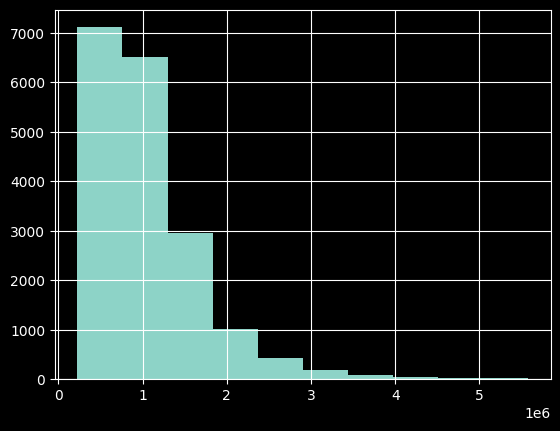

In [203]:
train['price'].hist()

In [204]:
train.columns

Index(['suburb', 'address', 'rooms', 'type', 'price', 'method', 'seller_g',
       'date', 'distance', 'postcode', 'bedroom2', 'bathroom', 'car',
       'landsize', 'building_area', 'year_built', 'council_area', 'lattitude',
       'longtitude', 'region_name', 'property_count', 'id', 'house', 'street',
       'median_year_built', 'median_year_built_council',
       'median_year_built_council_type', 'year_built_filled', 'mean_lattitude',
       'mean_longtitude'],
      dtype='object')

In [205]:
train['price'].describe()

count    1.837200e+04
mean     1.053254e+06
std      6.218090e+05
min      2.270000e+05
25%      6.350000e+05
50%      8.800000e+05
75%      1.301000e+06
max      5.580000e+06
Name: price, dtype: float64

# BaseLine


In [ ]:
mean_price = train['price'].mean()
median_price = train['price'].median()

In [ ]:
# test.head()

In [ ]:
# test.columns

In [ ]:
# test['mean_price'] = mean_price
# test['Price'] = median_price

In [ ]:
# test[['mean_price', 'median_price']].head()

In [ ]:
# test[['id','mean_price']].sample(15)

In [ ]:
# test[['id','Price']].to_csv('/content/median_price_submission.csv', index=False)

# Catboost

In [206]:
from catboost import CatBoostRegressor

## Создаем валидационную выборку

In [207]:
val, train1 = train_test_split(train,train_size=0.3,random_state=42)

In [211]:
print("Длина валидационной выборки:", len(val))
print("Длина тренировочного датасета:", len(train1))
print("Длина изначального тренировочного датасета:", len(val)+len(train1))

Длина валидационной выборки: 5511
Длина тренировочного датасета: 12861
Длина изначального тренировочного датасета: 18372


In [215]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8818 entries, 0 to 8817
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   suburb                          8818 non-null   object        
 1   address                         8818 non-null   object        
 2   rooms                           8818 non-null   int64         
 3   type                            8818 non-null   object        
 4   method                          8818 non-null   object        
 5   seller_g                        8818 non-null   object        
 6   date                            8818 non-null   datetime64[ns]
 7   distance                        8818 non-null   float64       
 8   postcode                        8818 non-null   int64         
 9   bedroom2                        5858 non-null   float64       
 10  bathroom                        5854 non-null   float64       
 11  car 

In [213]:
test.isna().sum().sort_values()

suburb                               0
year_built_filled                    0
median_year_built_council            0
street                               0
house                                0
id                                   0
property_count                       0
region_name                          0
longtitude                           0
lattitude                            0
council_area                         0
mean_lattitude                       0
mean_longtitude                      0
car                                  0
postcode                             0
distance                             0
date                                 0
seller_g                             0
method                               0
type                                 0
rooms                                0
address                              0
median_year_built                    3
median_year_built_council_type       7
bedroom2                          2960
bathroom                 

## Настройка Модели

In [216]:
test.dropna(axis=1).columns

Index(['suburb', 'address', 'rooms', 'type', 'method', 'seller_g', 'date',
       'distance', 'postcode', 'car', 'council_area', 'lattitude',
       'longtitude', 'region_name', 'property_count', 'id', 'house', 'street',
       'median_year_built_council', 'year_built_filled', 'mean_lattitude',
       'mean_longtitude'],
      dtype='object')

In [218]:
X = ['suburb', 'rooms', 'type', 'method', 'seller_g',
     'date', 'postcode', 'distance', 'street','house', 'car',
     'year_built_filled', 'lattitude', 'longtitude', 'council_area', 'property_count'
       ]

cat_features = ['suburb', 'postcode', 'type', 'method', 'seller_g', 'street', 'house', 'council_area']

y = ['price']

In [378]:
X = ['suburb', 'rooms', 'type', 'method', 'seller_g',
       'date', 'distance', 'bedroom2', 'bathroom', 'car', 'street', 'house',
       'landsize', 'building_area', 'year_built', 'council_area', 'lattitude',
       'longtitude', 'region_name', 'property_count']

cat_features = ['suburb','type','method','seller_g','council_area', 'street', 'house','region_name']

y = ['price']

In [385]:
parameters = {'cat_features': cat_features,
              'eval_metric': 'MAPE',
              'random_seed':42,
              'learning_rate': 0.085,
              'verbose':100}

In [386]:
model = CatBoostRegressor(**parameters)

In [387]:
model.fit(train1[X], train1[y], eval_set=(val[X],val[y]))

0:	learn: 0.5062887	test: 0.5053251	best: 0.5053251 (0)	total: 106ms	remaining: 1m 46s
100:	learn: 0.1692727	test: 0.1711911	best: 0.1711911 (100)	total: 5.04s	remaining: 44.9s
200:	learn: 0.1546420	test: 0.1601245	best: 0.1601245 (200)	total: 8.18s	remaining: 32.5s
300:	learn: 0.1456097	test: 0.1545467	best: 0.1545467 (300)	total: 11.4s	remaining: 26.4s
400:	learn: 0.1403244	test: 0.1518584	best: 0.1518581 (396)	total: 15.3s	remaining: 22.9s
500:	learn: 0.1355961	test: 0.1500733	best: 0.1500733 (500)	total: 20.1s	remaining: 20s
600:	learn: 0.1316172	test: 0.1490471	best: 0.1490471 (600)	total: 23.3s	remaining: 15.5s
700:	learn: 0.1282334	test: 0.1480049	best: 0.1480049 (700)	total: 26.5s	remaining: 11.3s
800:	learn: 0.1250106	test: 0.1474102	best: 0.1473773 (793)	total: 30.9s	remaining: 7.67s
900:	learn: 0.1225213	test: 0.1470971	best: 0.1470718 (883)	total: 35.3s	remaining: 3.88s
999:	learn: 0.1204281	test: 0.1468679	best: 0.1468359 (979)	total: 38.5s	remaining: 0us

bestTest = 0.146

bestTest = 0.1468358901

Нашли лучшую итерацию с использованием валидационной выборки

In [388]:
model.best_iteration_ + 1

980

In [389]:
parameters = {'cat_features': cat_features,
              'iterations': model.best_iteration_ + 1,
              'eval_metric': 'MAPE',
              'random_seed':42,
              'learning_rate': 0.085,
              'verbose':100}

Теперь обучим модель на полных данных, чтобы получить более лучший результат.

In [390]:
model = CatBoostRegressor(**parameters)

In [391]:
len(train)

18372

In [392]:
model.fit(train[X], train[y])

0:	learn: 0.5043089	total: 44.6ms	remaining: 43.7s
100:	learn: 0.1702322	total: 4.25s	remaining: 37s
200:	learn: 0.1561197	total: 9.43s	remaining: 36.6s
300:	learn: 0.1480053	total: 12.9s	remaining: 29.2s
400:	learn: 0.1421507	total: 16.5s	remaining: 23.9s
500:	learn: 0.1377650	total: 24.1s	remaining: 23.1s
600:	learn: 0.1341647	total: 29.1s	remaining: 18.4s
700:	learn: 0.1311159	total: 32.8s	remaining: 13s
800:	learn: 0.1282485	total: 38.7s	remaining: 8.65s
900:	learn: 0.1259119	total: 42.4s	remaining: 3.72s
979:	learn: 0.1242764	total: 45.3s	remaining: 0us


0.1241415

In [393]:
model.predict(test[X])

array([1081342.91660594, 1473466.02626355, 1373674.96580953, ...,
        727196.48703868,  961396.00652765,  812808.61681924])

In [394]:
test['price_pred'] = model.predict(test[X])

In [395]:
test[['id','price_pred']]

,id,price_pred
0,30130,1.081343e+06
1,18311,1.473466e+06
2,18934,1.373675e+06
3,1824,7.979020e+05
4,31339,8.580648e+05
...,...,...
8813,11120,1.290201e+06
8814,3950,8.067172e+05
8815,2209,7.271965e+05
8816,23872,9.613960e+05


In [396]:
test['Price'] = test['price_pred']

In [397]:
test[['id','Price']].to_csv('/content/all_features1_submission.csv', index=False)

#Анализ ошибок

In [352]:
train['price_pred'] = model.predict(train[X])

In [353]:
train['error'] = train['price_pred'] - train['price']

<Axes: >

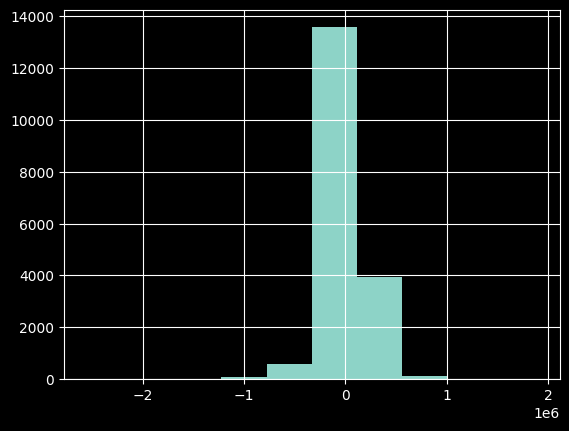

In [354]:
train['error'].hist()

In [355]:
 train['error'].mean()

7458.905090830878

Видим что моя модель немного завышает

In [356]:
train['error_abs'] = abs(train['error'])

<Axes: >

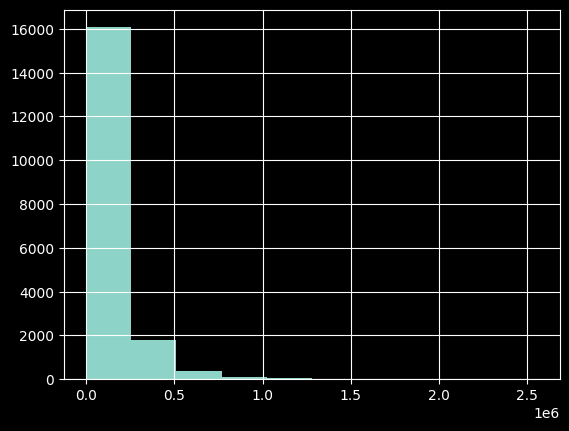

In [357]:
train['error_abs'].hist()

In [358]:
train['error_abs'].describe()

count    1.837200e+04
mean     1.286340e+05
std      1.531258e+05
min      3.973275e-01
25%      3.796425e+04
50%      8.314253e+04
75%      1.621695e+05
max      2.558453e+06
Name: error_abs, dtype: float64

In [359]:
train.sort_values('error_abs',ascending = False).head(5)

,suburb,address,rooms,type,price,method,seller_g,date,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,property_count,id,house,street,median_year_built,median_year_built_council,median_year_built_council_type,year_built_filled,mean_lattitude,mean_longtitude,price_pred,error,error_abs,price_group,distance_group,landsize_group
4544,kew,51 Rowland St,2,h,4800000.0,S,Jellis,2016-09-03,5.6,3101,2.0,2.0,1,697.0,NaN,NaN,Boroondara City Council,-37.812000,145.054700,Southern Metropolitan,10331.0,30645,51,rowland st,1945.0,1960.0,1940.0,1940,-37.805838,145.039329,2.241547e+06,-2.558453e+06,2.558453e+06,"(1416000.0, 5580000.0]","(5.5, 8.4]","(690.0, 433014.0]"
327,armadale,11/17 Myamyn St,2,u,3625000.0,S,Jellis,2016-06-04,6.3,3143,3.0,2.0,2,0.0,NaN,2006.0,Stonnington City Council,-37.855500,145.029100,Southern Metropolitan,4836.0,12643,11/17,myamyn st,1970.0,1951.0,1970.0,2006,-37.857144,145.019472,1.243465e+06,-2.381535e+06,2.381535e+06,"(1416000.0, 5580000.0]","(5.5, 8.4]","(-0.001, 137.0]"
1321,box hill,6 Archibald St,3,h,4000000.0,VB,Lindellas,2016-06-18,13.1,3128,3.0,1.0,2,763.0,120.0,1945.0,Whitehorse City Council,-37.816600,145.121500,Eastern Metropolitan,4605.0,22167,6,archibald st,1970.0,1970.0,1965.0,1945,-37.821444,145.122156,1.710480e+06,-2.289520e+06,2.289520e+06,"(1416000.0, 5580000.0]","(11.2, 13.9]","(690.0, 433014.0]"
1502,brighton,11 Kent Av,4,h,5250000.0,VB,hockingstuart,2016-06-27,11.2,3186,NaN,NaN,0,NaN,NaN,NaN,Bayside City Council,-37.896129,144.987157,Southern Metropolitan,10579.0,16395,11,kent av,1945.0,1970.0,1950.0,1950,-37.908569,144.997542,3.235145e+06,-2.014855e+06,2.014855e+06,"(1416000.0, 5580000.0]","(8.4, 11.2]",NaN
13415,south melbourne,47 Howe Cr,3,h,4600000.0,S,Marshall,2017-05-27,1.9,3205,NaN,NaN,0,NaN,NaN,NaN,Port Phillip City Council,-37.839085,144.959399,Southern Metropolitan,5943.0,335,47,howe cr,1945.0,1945.0,1900.0,1900,-37.835180,144.960567,2.600299e+06,-1.999701e+06,1.999701e+06,"(1416000.0, 5580000.0]","(-0.001, 5.5]",NaN


In [360]:
train['price_group']=pd.qcut(train['price'],5)

In [361]:
train.head(5)

,suburb,address,rooms,type,price,method,seller_g,date,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,property_count,id,house,street,median_year_built,median_year_built_council,median_year_built_council_type,year_built_filled,mean_lattitude,mean_longtitude,price_pred,error,error_abs,price_group,distance_group,landsize_group
0,abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-12-03,2.5,3067,2.0,1.0,1,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0,34302,85,turner st,1960.0,1950.0,1900.0,1900,-37.804542,145.001602,1.174692e+06,-305308.175767,305308.175767,"(1416000.0, 5580000.0]","(-0.001, 5.5]","(137.0, 312.0]"
1,abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-02-04,2.5,3067,2.0,1.0,0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0,33247,25,bloomburg st,1960.0,1950.0,1900.0,1900,-37.804542,145.001602,8.949114e+05,-140088.593171,140088.593171,"(1005000.0, 1416000.0]","(-0.001, 5.5]","(137.0, 312.0]"
2,abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-03-04,2.5,3067,3.0,2.0,0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0,31886,5,charles st,1960.0,1950.0,1900.0,1900,-37.804542,145.001602,1.338010e+06,-126990.283774,126990.283774,"(1416000.0, 5580000.0]","(-0.001, 5.5]","(-0.001, 137.0]"
3,abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-03-04,2.5,3067,3.0,2.0,1,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0,18999,40,federation la,1960.0,1950.0,1900.0,1900,-37.804542,145.001602,1.217920e+06,367920.418557,367920.418557,"(777000.0, 1005000.0]","(-0.001, 5.5]","(-0.001, 137.0]"
4,abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-06-04,2.5,3067,3.0,1.0,2,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0,16809,55a,park st,1960.0,1950.0,1900.0,2014,-37.804542,145.001602,1.380685e+06,-219315.472297,219315.472297,"(1416000.0, 5580000.0]","(-0.001, 5.5]","(-0.001, 137.0]"


In [362]:
t = train.groupby('price_group')[['error_abs','error']].agg(['count', 'mean'])

In [363]:
t.columns = ['_'.join(col).strip() for col in t.columns.values]

In [364]:
t = t.drop('error_count', axis=1 )

In [365]:
t['mean_error_diff'] = t['error_abs_mean'] - train['error_abs'].mean()

In [366]:
t['mean_error'] = train['error_abs'].mean()

In [367]:
t

,error_abs_count,error_abs_mean,error_mean,mean_error_diff,mean_error
price_group,,,,,
"(226999.999, 590000.0]",3702,67364.449839,41912.772999,-61269.566787,128634.016626
"(590000.0, 777000.0]",3649,76134.890729,16574.600758,-52499.125897,128634.016626
"(777000.0, 1005000.0]",3683,110927.932585,46275.441346,-17706.084040,128634.016626
"(1005000.0, 1416000.0]",3664,138916.973662,31849.388086,10282.957036,128634.016626
"(1416000.0, 5580000.0]",3674,250006.907094,-99546.926484,121372.890468,128634.016626


In [368]:
train['error_abs'].mean()

128634.01662588646

In [369]:
error(train['price'],train['price_pred'])

Absolute error: 128634.0
Absolute percentage error: 12.45%


## Анализ средней абсолютной ошибки

In [370]:
import seaborn as sns
cm = sns.dark_palette("red", as_cmap=True)

In [371]:
t.style.background_gradient(cmap=cm, subset = 'mean_error_diff')

,error_abs_count,error_abs_mean,error_mean,mean_error_diff,mean_error
price_group,,,,,
"(226999.999, 590000.0]",3702,67364.449839,41912.772999,-61269.566787,128634.016626
"(590000.0, 777000.0]",3649,76134.890729,16574.600758,-52499.125897,128634.016626
"(777000.0, 1005000.0]",3683,110927.932585,46275.441346,-17706.084040,128634.016626
"(1005000.0, 1416000.0]",3664,138916.973662,31849.388086,10282.957036,128634.016626
"(1416000.0, 5580000.0]",3674,250006.907094,-99546.926484,121372.890468,128634.016626


Видим, что лучше всего модель работает на данных в ценовом диапазоне (226999.999, 590000.0]	то есть для недвижимости из маленькой ценовой категории.

А сильнее всего ошибается на более высоких ценах.

##Анализ абсолютной ошибки относительно остальных переменных

In [372]:
train.head()

,suburb,address,rooms,type,price,method,seller_g,date,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,property_count,id,house,street,median_year_built,median_year_built_council,median_year_built_council_type,year_built_filled,mean_lattitude,mean_longtitude,price_pred,error,error_abs,price_group,distance_group,landsize_group
0,abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-12-03,2.5,3067,2.0,1.0,1,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0,34302,85,turner st,1960.0,1950.0,1900.0,1900,-37.804542,145.001602,1.174692e+06,-305308.175767,305308.175767,"(1416000.0, 5580000.0]","(-0.001, 5.5]","(137.0, 312.0]"
1,abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-02-04,2.5,3067,2.0,1.0,0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0,33247,25,bloomburg st,1960.0,1950.0,1900.0,1900,-37.804542,145.001602,8.949114e+05,-140088.593171,140088.593171,"(1005000.0, 1416000.0]","(-0.001, 5.5]","(137.0, 312.0]"
2,abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-03-04,2.5,3067,3.0,2.0,0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0,31886,5,charles st,1960.0,1950.0,1900.0,1900,-37.804542,145.001602,1.338010e+06,-126990.283774,126990.283774,"(1416000.0, 5580000.0]","(-0.001, 5.5]","(-0.001, 137.0]"
3,abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-03-04,2.5,3067,3.0,2.0,1,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0,18999,40,federation la,1960.0,1950.0,1900.0,1900,-37.804542,145.001602,1.217920e+06,367920.418557,367920.418557,"(777000.0, 1005000.0]","(-0.001, 5.5]","(-0.001, 137.0]"
4,abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-06-04,2.5,3067,3.0,1.0,2,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0,16809,55a,park st,1960.0,1950.0,1900.0,2014,-37.804542,145.001602,1.380685e+06,-219315.472297,219315.472297,"(1416000.0, 5580000.0]","(-0.001, 5.5]","(-0.001, 137.0]"


In [373]:
X

['suburb',
 'rooms',
 'type',
 'method',
 'seller_g',
 'date',
 'distance',
 'bedroom2',
 'bathroom',
 'car',
 'street',
 'house',
 'landsize',
 'building_area',
 'year_built_filled',
 'council_area',
 'lattitude',
 'longtitude',
 'region_name',
 'property_count']

In [374]:
def print_error(col):
  t = train.groupby(col)[['error_abs','error']].agg(['count', 'mean'])
  t.columns = ['_'.join(col).strip() for col in t.columns.values]
  t = t.drop('error_count', axis=1 )
  t['mean_error_diff'] = t['error_abs_mean'] - train['error_abs'].mean()
  t['mean_error'] = train['error_abs'].mean()
  display(t.style.background_gradient(cmap=cm, subset = 'mean_error_diff'))

In [375]:
train['distance_group'] = pd.qcut(train['distance'],5)

In [376]:
print_error('distance_group')

,error_abs_count,error_abs_mean,error_mean,mean_error_diff,mean_error
distance_group,,,,,
"(-0.001, 5.5]",3746,155674.129650,11513.816726,27040.113024,128634.016626
"(5.5, 8.4]",3822,149724.714600,10264.898677,21090.697975,128634.016626
"(8.4, 11.2]",4066,133651.785808,3050.445472,5017.769182,128634.016626
"(11.2, 13.9]",3398,103883.493970,4068.047672,-24750.522656,128634.016626
"(13.9, 48.1]",3340,93244.530232,8516.606841,-35389.486394,128634.016626


In [377]:
model.get_feature_importance(prettified = True)

,Feature Id,Importances
0,rooms,17.053014
1,distance,9.973177
2,region_name,9.727864
3,suburb,7.197014
4,year_built_filled,7.102292
5,landsize,7.017389
6,type,6.861909
7,council_area,4.727040
8,building_area,4.638453
9,bathroom,4.525720


### Анализ связи атрибутов с помощью библиотеки phik

In [259]:
! pip install phik

In [260]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [261]:
phik_overview = train[X].phik_matrix()

interval columns not set, guessing: ['rooms', 'postcode', 'distance', 'car', 'year_built_filled', 'lattitude', 'longtitude', 'property_count']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable house is large: 3636. Are you sure this is not an interval variable? Analysis for pairs of variables including house can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable street is large: 6890. Are you sure this is not an interval variable? Analysis for pairs of variables including street can be slow.
  warnings.warn(


<Axes: >

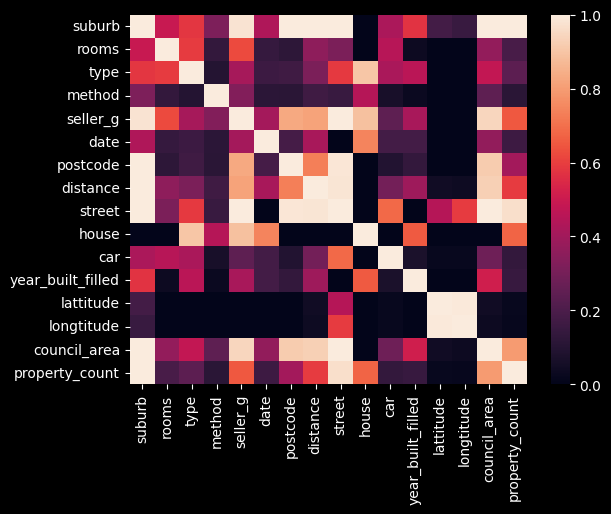

In [262]:
sns.heatmap(phik_overview)

In [263]:
phik_overview['price'].sort_values(ascending=False)

KeyError: ignored

# Feature importances

In [307]:
imp = model.get_feature_importance(prettified=True)

In [308]:
imp

,Feature Id,Importances
0,rooms,22.692007
1,distance,10.497056
2,council_area,9.803067
3,type,8.640582
4,year_built_filled,6.812527
5,longtitude,6.660196
6,postcode,6.186971
7,seller_g,5.572243
8,lattitude,5.330913
9,suburb,3.955229


# Shap

In [265]:
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.3 MB/s eta 0:00:00


In [266]:
import shap
shap.initjs()

In [267]:
X

['suburb',
 'rooms',
 'type',
 'method',
 'seller_g',
 'date',
 'postcode',
 'distance',
 'street',
 'house',
 'car',
 'year_built_filled',
 'lattitude',
 'longtitude',
 'council_area',
 'property_count']

In [286]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train[X])

In [287]:
pd.DataFrame(shap_values,columns=X)

,suburb,rooms,type,method,seller_g,date,postcode,distance,street,house,car,year_built_filled,lattitude,longtitude,council_area,property_count
0,14772.281216,-269064.227523,106093.357591,10697.497813,-23156.199131,25359.674786,41366.271381,85598.361501,18179.721600,30897.451631,-31030.704037,102390.891457,-19090.851793,15964.066991,40322.443706,-18814.389453
1,24082.864733,-270972.757738,102428.253295,12662.657381,-21540.454140,-15782.946466,49302.475987,62592.726550,21439.283484,57584.661469,-69965.959551,29905.213139,9707.101043,358.491564,39348.227632,-15071.315439
2,40913.981512,-41974.762165,90446.638838,-40768.262006,-34153.896029,30675.455953,47045.397094,98362.880791,30614.206335,77453.343731,-78015.581442,3084.351965,33476.941523,-2319.792732,72712.173863,-28386.750644
3,32396.428970,-35547.953684,80026.376842,-54420.668665,-43455.443786,30273.256091,47544.193433,101163.940358,-31067.595598,55964.879452,-33158.570996,71202.102750,-33778.066496,7467.975732,73493.902356,-21078.081173
4,44994.909709,348176.754198,91418.955562,-50924.158592,-28595.792513,-71651.018521,86124.613151,182666.148148,6954.430415,2679.365290,25035.040544,3522.606663,19873.062022,10522.156168,121000.597804,-20078.264174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18367,-56928.518797,-5365.510076,-64515.736276,-26439.388723,-38712.324347,22038.259429,-70345.645847,-162988.028705,-9185.490610,41895.032378,185153.949583,-42641.832128,9233.678369,-42789.999317,-136256.712246,12463.120113
18368,-70019.579950,11274.089736,-125136.323070,-12085.754961,-18579.377887,39324.162136,-54610.622519,-39687.840093,-4745.006603,53884.640857,-36631.222166,-22505.443319,-108289.264141,-1919.557199,-88353.991851,-918.331925
18369,-62988.492821,177211.960244,-80407.524454,10263.719734,-22166.885202,32241.430440,-50045.678229,-126121.580249,-11535.246431,33744.612190,19965.291073,-18023.274548,-134750.147832,-15023.676217,-176157.876738,5404.814330
18370,-46334.140453,1046.020458,-60217.046618,5317.023900,-24761.994383,28556.905341,-21680.434150,-118729.349563,-9682.894921,40169.291106,-36171.839207,-27424.555725,39042.991190,-8589.552720,-118390.124709,-8711.002096


In [288]:
train['price'].mean()

1053253.5647180493

In [289]:
test1 = train.copy()

In [290]:
test1['date'] = test1['date'].astype('str')

In [291]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], test1[X].iloc[0,:])

# Топ 10 ошибок

In [292]:
shap_cols = [x+'_shap' for x in X]

In [293]:
shap_cols

['suburb_shap',
 'rooms_shap',
 'type_shap',
 'method_shap',
 'seller_g_shap',
 'date_shap',
 'postcode_shap',
 'distance_shap',
 'street_shap',
 'house_shap',
 'car_shap',
 'year_built_filled_shap',
 'lattitude_shap',
 'longtitude_shap',
 'council_area_shap',
 'property_count_shap']

In [294]:
shap_values_df = pd.DataFrame(shap_values,columns=shap_cols)

In [295]:
shap_values_df

,suburb_shap,rooms_shap,type_shap,method_shap,seller_g_shap,date_shap,postcode_shap,distance_shap,street_shap,house_shap,car_shap,year_built_filled_shap,lattitude_shap,longtitude_shap,council_area_shap,property_count_shap
0,14772.281216,-269064.227523,106093.357591,10697.497813,-23156.199131,25359.674786,41366.271381,85598.361501,18179.721600,30897.451631,-31030.704037,102390.891457,-19090.851793,15964.066991,40322.443706,-18814.389453
1,24082.864733,-270972.757738,102428.253295,12662.657381,-21540.454140,-15782.946466,49302.475987,62592.726550,21439.283484,57584.661469,-69965.959551,29905.213139,9707.101043,358.491564,39348.227632,-15071.315439
2,40913.981512,-41974.762165,90446.638838,-40768.262006,-34153.896029,30675.455953,47045.397094,98362.880791,30614.206335,77453.343731,-78015.581442,3084.351965,33476.941523,-2319.792732,72712.173863,-28386.750644
3,32396.428970,-35547.953684,80026.376842,-54420.668665,-43455.443786,30273.256091,47544.193433,101163.940358,-31067.595598,55964.879452,-33158.570996,71202.102750,-33778.066496,7467.975732,73493.902356,-21078.081173
4,44994.909709,348176.754198,91418.955562,-50924.158592,-28595.792513,-71651.018521,86124.613151,182666.148148,6954.430415,2679.365290,25035.040544,3522.606663,19873.062022,10522.156168,121000.597804,-20078.264174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18367,-56928.518797,-5365.510076,-64515.736276,-26439.388723,-38712.324347,22038.259429,-70345.645847,-162988.028705,-9185.490610,41895.032378,185153.949583,-42641.832128,9233.678369,-42789.999317,-136256.712246,12463.120113
18368,-70019.579950,11274.089736,-125136.323070,-12085.754961,-18579.377887,39324.162136,-54610.622519,-39687.840093,-4745.006603,53884.640857,-36631.222166,-22505.443319,-108289.264141,-1919.557199,-88353.991851,-918.331925
18369,-62988.492821,177211.960244,-80407.524454,10263.719734,-22166.885202,32241.430440,-50045.678229,-126121.580249,-11535.246431,33744.612190,19965.291073,-18023.274548,-134750.147832,-15023.676217,-176157.876738,5404.814330
18370,-46334.140453,1046.020458,-60217.046618,5317.023900,-24761.994383,28556.905341,-21680.434150,-118729.349563,-9682.894921,40169.291106,-36171.839207,-27424.555725,39042.991190,-8589.552720,-118390.124709,-8711.002096


In [296]:
test1

,suburb,address,rooms,type,price,method,seller_g,date,distance,postcode,bedroom2,bathroom,car,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,property_count,id,house,street,median_year_built,median_year_built_council,median_year_built_council_type,year_built_filled,mean_lattitude,mean_longtitude,price_pred,error,error_abs,price_group,distance_group
0,abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-12-03,2.5,3067,2.0,1.0,1,202.0,NaN,NaN,Yarra City Council,-37.79960,144.99840,Northern Metropolitan,4019.0,34302,85,turner st,1960.0,1950.0,1900.0,1900,-37.804542,145.001602,1.183722e+06,-296278.329937,296278.329937,"(1416000.0, 5580000.0]","(-0.001, 5.5]"
1,abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-02-04,2.5,3067,2.0,1.0,0,156.0,79.0,1900.0,Yarra City Council,-37.80790,144.99340,Northern Metropolitan,4019.0,33247,25,bloomburg st,1960.0,1950.0,1900.0,1900,-37.804542,145.001602,1.069315e+06,34314.545271,34314.545271,"(1005000.0, 1416000.0]","(-0.001, 5.5]"
2,abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-03-04,2.5,3067,3.0,2.0,0,134.0,150.0,1900.0,Yarra City Council,-37.80930,144.99440,Northern Metropolitan,4019.0,31886,5,charles st,1960.0,1950.0,1900.0,1900,-37.804542,145.001602,1.352402e+06,-112597.651086,112597.651086,"(1416000.0, 5580000.0]","(-0.001, 5.5]"
3,abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-03-04,2.5,3067,3.0,2.0,1,94.0,NaN,NaN,Yarra City Council,-37.79690,144.99690,Northern Metropolitan,4019.0,18999,40,federation la,1960.0,1950.0,1900.0,1900,-37.804542,145.001602,1.300263e+06,450262.697912,450262.697912,"(777000.0, 1005000.0]","(-0.001, 5.5]"
4,abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-06-04,2.5,3067,3.0,1.0,2,120.0,142.0,2014.0,Yarra City Council,-37.80720,144.99410,Northern Metropolitan,4019.0,16809,55a,park st,1960.0,1950.0,1900.0,2014,-37.804542,145.001602,1.824955e+06,224955.428200,224955.428200,"(1416000.0, 5580000.0]","(-0.001, 5.5]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18367,noble park,5 Blaby St,3,h,627500.0,PI,C21,2017-09-30,22.7,3174,3.0,1.0,6,569.0,130.0,1959.0,Greater Dandenong City Council,-37.96900,145.18226,South-Eastern Metropolitan,11806.0,8052,5,blaby st,1975.0,1970.0,1970.0,1959,-37.968622,145.179869,6.678509e+05,40350.875128,40350.875128,"(590000.0, 777000.0]","(13.9, 48.1]"
18368,reservoir,18 Elinda Pl,3,u,475000.0,SP,RW,2017-09-30,12.0,3073,3.0,1.0,1,NaN,105.0,1990.0,Darebin City Council,-37.69769,145.02332,Northern Metropolitan,21650.0,22511,18,elinda pl,1990.0,1960.0,1975.0,1990,-37.715183,145.012113,5.742366e+05,99236.599372,99236.599372,"(226999.999, 590000.0]","(11.2, 13.9]"
18369,roxburgh park,14 Stainsby Cr,4,h,591000.0,S,Raine,2017-09-30,20.6,3064,4.0,2.0,2,NaN,225.0,1995.0,Hume City Council,-37.63665,144.92976,Northern Metropolitan,5833.0,31811,14,stainsby cr,1960.0,1994.0,1990.0,1995,-37.631259,144.929900,6.348475e+05,43847.467616,43847.467616,"(590000.0, 777000.0]","(13.9, 48.1]"
18370,springvale south,30 Waddington Cr,3,h,780500.0,S,Harcourts,2017-09-30,22.2,3172,3.0,2.0,1,544.0,NaN,NaN,Greater Dandenong City Council,-37.97751,145.14813,South-Eastern Metropolitan,4054.0,6855,30,waddington cr,1975.0,1970.0,1970.0,1970,-37.972946,145.151417,6.866753e+05,-93824.680223,93824.680223,"(777000.0, 1005000.0]","(13.9, 48.1]"


In [297]:
test_shap = pd.concat([test1.reset_index(),shap_values_df],axis=1)

In [298]:
len(test1)

18372

In [299]:
test_shap = test_shap.sort_values('error_abs',ascending=False)

In [300]:
shap.initjs()
shap.force_plot(explainer.expected_value, test_shap[shap_cols].values[0,:], test_shap[X].iloc[0,:])

In [301]:
print_error('type')

,error_abs_count,error_abs_mean,error_mean,mean_error_diff,mean_error
type,,,,,
h,12091,179716.717259,9460.640726,25936.249021,153780.468238
t,2007,116343.838209,15354.966893,-37436.630029,153780.468238
u,4274,97987.330558,-1822.215171,-55793.137680,153780.468238


In [302]:
shap.initjs()
shap.force_plot(explainer.expected_value, test_shap[shap_cols].head(10).values, test_shap[X].head(10))

# Dependence plot

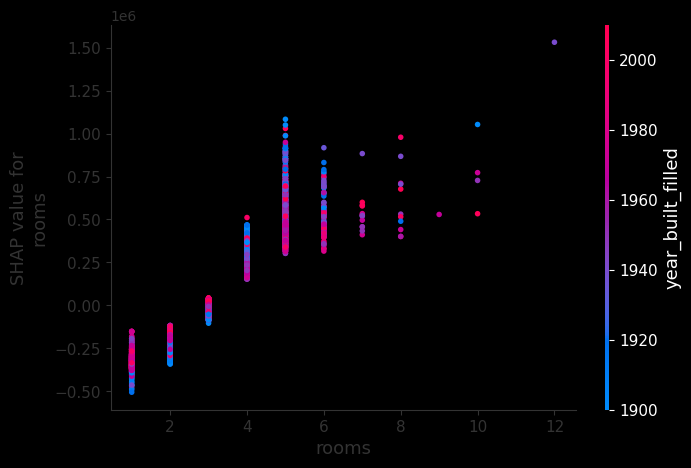

In [303]:
shap.dependence_plot('rooms', shap_values, test1[X])

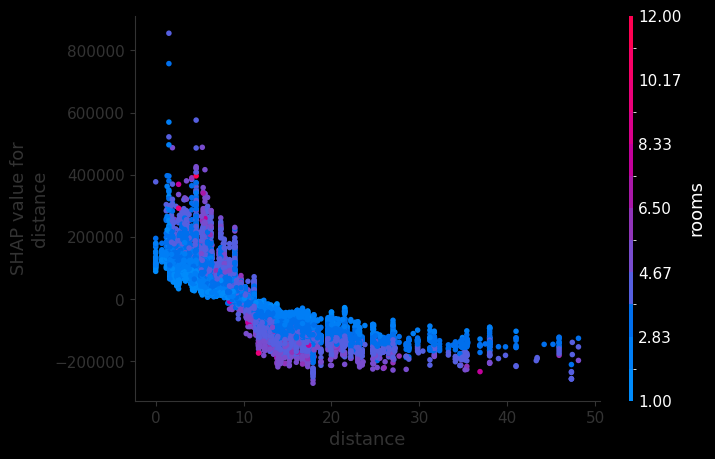

In [305]:
shap.dependence_plot('distance', shap_values, test1[X])

In [ ]:
shap.dependence_plot('distance', shap_values, test1[X])

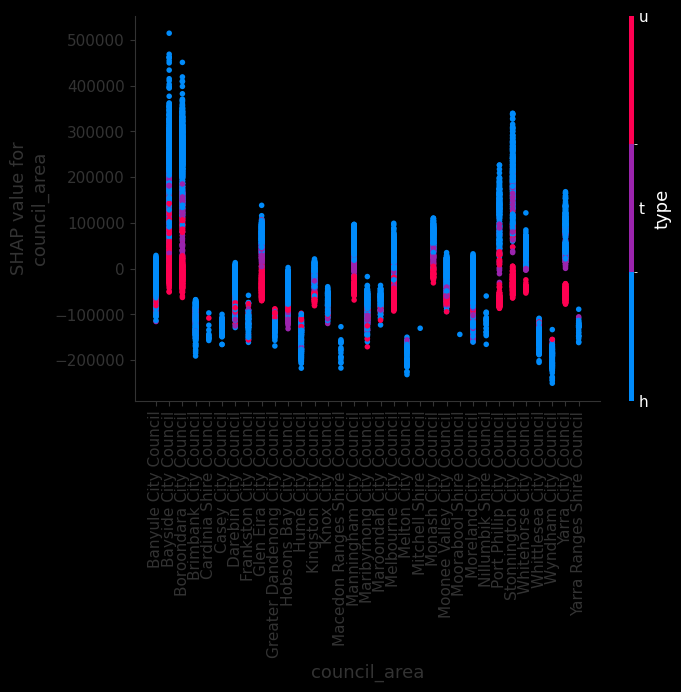

In [309]:
shap.dependence_plot('council_area', shap_values, test1[X])

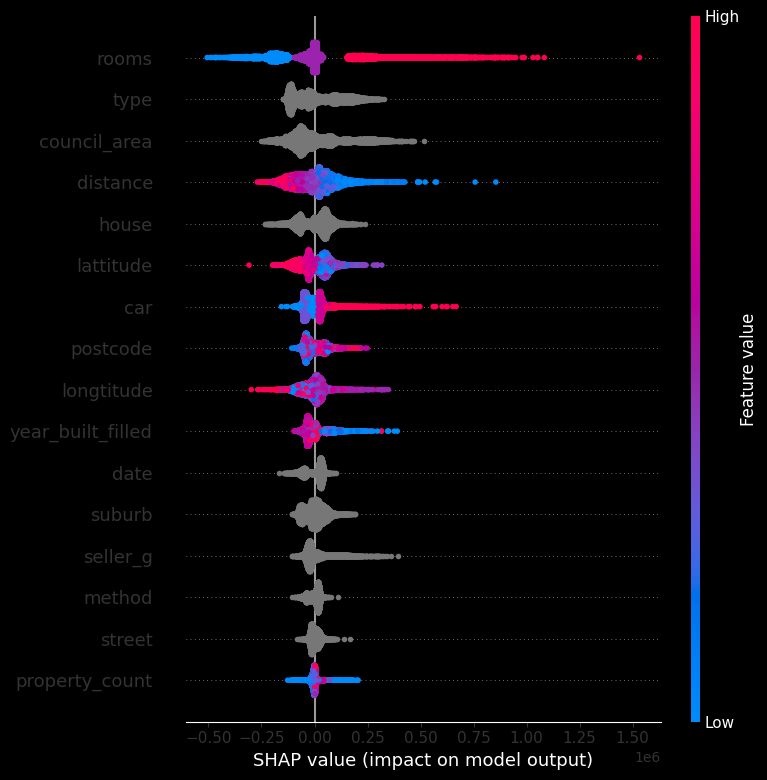

In [316]:
shap.summary_plot(shap_values, train[X])